# Voice Recognition

## 1. Data Set definitions

#### 1.1 DataSet for Audio Data

In [3]:
import torch
from torch.utils.data import Dataset
import librosa
import os

class AudioDataset(Dataset):
    def __init__(self, data_frame, preprocess, sample_rate=16000):
        self.data = data_frame[['file_path', 'start_time', 'end_time', 'functions', 'parameters']]
        self.preprocess = preprocess
        self.sample_rate = sample_rate

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):        
        row = self.data.iloc[idx]
        audio_path = os.path.normpath(row['file_path']).replace('\\', '/') # 'replace' for Colab
        start_time = row['start_time']
        end_time = row['end_time']
        f = row.get('functions', default=[])
        functions = [] if f == [] else [row['functions']]
        p = row.get('parameters', default=[])
        parameters = [] if p == [] else [row['parameters']]

        # Convert start and end times to timestamps
        start_time = float(start_time)
        end_time = float(end_time)

        # Calculate the duration of the audio chunk
        duration = end_time - start_time

        # Load the audio chunk using librosa
        audio_data, _ = librosa.load(audio_path,
                                               sr=self.sample_rate,
                                               offset=start_time,
                                               duration=duration)
        # Preprocess the audio chunk
        preprocess_audio_chunk = self.preprocess(audio_data, self.sample_rate, functions, parameters)
        preprocess_audio_chunk = torch.tensor(preprocess_audio_chunk.copy(), dtype=torch.double)

        return preprocess_audio_chunk
    

#### 1.2 DataSet for Label Data

In [4]:
from torch.utils.data import Dataset

class LabelDataset(Dataset):
    def __init__(self, data_frame, positive_label):
        # Map the label column to integers (1 if it matches the positive label, 0 otherwise)
        self.data = data_frame['label'].map(lambda x: int(x == positive_label))

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Get the label at the given index
        label = self.data.iloc[idx]
        return torch.tensor(float(label), dtype=torch.double)


## 2. Architecture -- VAD (Voice Activity Detector)

### 2.1 VAD Base Class

In [5]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm as tqdm
from colorama import Style

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")


class VoiceActivityDetectorBase(nn.Module):
    """
    Base abstract class for voice activity detection models.
    """
    def __init__(self, threshold=0.5):
        super(VoiceActivityDetectorBase, self).__init__()

        # Set the threshold and accumulation gradient batches
        self.threshold = threshold
        self.dtype = torch.double
        self = self.to(DEVICE, dtype=torch.double)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        raise NotImplementedError

    def train_model(self, audio_dataloader, label_dataloader, 
                    criterion, optimizer, epochs, learning_rate=1e-4, scheduler=None, verbose=True):
        """
        Train the model.

        Args:
            audio_dataloader (torch.utils.data.DataLoader): Dataloader for audio input.
            label_dataloader (torch.utils.data.DataLoader): Dataloader for label input.
            criterion: Loss function.
            optimizer: Optimization algorithm.
            epochs (int): Number of training epochs.
            scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler (default: None).
        """

        self = self.to(DEVICE)
        criterion = criterion.to(DEVICE)

        if callable(optimizer):
            optimizer = optimizer(self.parameters(), learning_rate)
        else:
            optimizer = optimizer

        if callable(scheduler):
            scheduler = scheduler(optimizer)
        else:
            scheduler = scheduler

        num_batches = len(audio_dataloader)

        for epoch in range(epochs):
            progress_bar = tqdm(total=num_batches,
                                desc="Training",
                                bar_format="{desc}  {bar}  " +
                                           Style.RESET_ALL +
                                           "{percentage:3.3f}% ({n_fmt}/{total_fmt}) [{elapsed}<{remaining}]",
                                ascii=" ╸╸╸╸┅┅┅┅━━━━",
                                disable=False,
                                ncols=120,
                                leave=False,
                                display=verbose)

            total_correct = 0
            total = 0

            # Training
            self.train()
            optimizer.zero_grad()

            for batch_inputs, batch_labels in zip(audio_dataloader, label_dataloader):
                progress_bar.update(1)
                # Shifting color from red to green
                # color = f"\033[38;2;{int(255 - ((batch_idx/num_batches) * 255))};{int((batch_idx/num_batches) * 255)};0m"
                # progress_bar.set_description_str(desc=f"{Style.RESET_ALL}Training: {color}")

                batch_inputs = batch_inputs.to(DEVICE, dtype=self.dtype)
                batch_labels = batch_labels.to(DEVICE, dtype=self.dtype)

                outputs = self.forward(batch_inputs)
                loss = criterion(outputs.squeeze(), batch_labels)

                # Compute accuracy
                predicted = self.pred_from_prob(outputs)
                total_correct += (predicted == batch_labels).sum().item()
                total += predicted.flatten().size(0)

                loss.backward()

                # Accumulate gradients over multiple batches
                optimizer.step()
                optimizer.zero_grad()

            # Update the learning rate based on the scheduler
            if scheduler is not None:
                scheduler.step()

            if verbose:
                # Calculate accuracy
                train_acc = total_correct / total

                print(f"\nEpoch {epoch + 1}/{epochs}:\n\tTrain -- Loss // Acc:\t{loss.item():.4f} // {train_acc:4.3%}")
            progress_bar.close()

    def predict_prob(self, audio_dataloader):
        """
        Predict probabilities of audio samples.

        Args:
            audio_dataloader (torch.utils.data.DataLoader): Dataloader for audio input.

        Returns:
            torch.Tensor: Predicted probabilities of shape (num_samples, output_size).
        """
        self = self.to(DEVICE)

        self.eval()  # Set the model to evaluation mode
        predictions = []

        with torch.no_grad():
            for batch_inputs in audio_dataloader:
                batch_inputs = batch_inputs.to(DEVICE, dtype=self.dtype)
                outputs = self.forward(batch_inputs)
                predictions.append(outputs)

        predictions = torch.cat(predictions, dim=0)
        predictions = torch.sigmoid_(predictions).flatten()

        return predictions


    def predict_class(self, audio_dataloader):
        """
        Predict classes (0 or 1) based on probabilities.

        Args:
            audio_dataloader (torch.utils.data.DataLoader): Dataloader for audio input.

        Returns:
            torch.Tensor: Predicted classes of shape (num_samples,).
        """
        probabilities = self.predict_prob(audio_dataloader)
        return self.pred_from_prob(probabilities).cpu()

    def pred_from_prob(self, probabilities):
        """
        Convert probabilities to classes based on the threshold.

        Args:
            probabilities (torch.Tensor): Predicted probabilities.

        Returns:
            torch.Tensor: Predicted classes based on the threshold.
        """
        classes = (probabilities >= self.threshold).float()  # Apply threshold in-place
        return classes

    def eval_model(self, audio_dataloader, label_dataloader):
        """
        Evaluate the model on the provided data.

        Args:
            audio_dataloader (torch.utils.data.DataLoader): Dataloader for audio input.
            label_dataloader (torch.utils.data.DataLoader): Dataloader for label input.

        Returns:
            float: Accuracy of the model on the provided data.
        """
        self = self.to(DEVICE)

        self.eval()
        total_samples = 0
        correct_predictions = 0

        with torch.no_grad():
            for batch_inputs, batch_labels in zip(audio_dataloader, label_dataloader):
                batch_inputs = batch_inputs.to(DEVICE, dtype=self.dtype)
                batch_labels = batch_labels.to(DEVICE, dtype=self.dtype)

                outputs = self.forward(batch_inputs)
                predicted_labels = torch.round(torch.sigmoid_(outputs.squeeze()))
                total_samples += batch_labels.size(0)
                correct_predictions += (predicted_labels == batch_labels).sum().item()

        accuracy = correct_predictions / total_samples
        return accuracy

    def save_model(self, filepath):
        """
        Save the model to a file.

        Args:
            filepath (str): Path to the file where the model will be saved.
        """
        raise NotImplementedError

    @classmethod
    def load_model(cls, filepath):
        """
        Load the model from a file.

        Args:
            filepath (str): Path to the file where the model is saved.

        Returns:
            VoiceActivityDetectorBase: Loaded model.
        """
        raise NotImplementedError

### 2.2 LSTM Based Implementation

#### 2.1.1 LSTM-VAD Implementation

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm as tqdm
from colorama import Style

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM_VAD(VoiceActivityDetectorBase):
    """
    Voice Activity Detector (VAD) model for audio classification.

    Args:
        input_size (int): Size of the input features.
        hidden_size (int): Size of the hidden LSTM layer.
        num_layers (int): Number of LSTM layers.
        output_size (int): Size of the output layer.
        threshold (float, optional): Threshold value for classification (default: 0.5).

    Attributes:
        lstm (nn.LSTM): LSTM layer for sequential processing.
        fc (nn.Linear): Fully connected layer for classification.
        threshold (float): Threshold value for classification.

    Methods:
        forward(x): Forward pass of the model.
        train_model(audio_dataloader, label_dataloader, criterion, optimizer, epochs, scheduler=None):
            Train the model.
        predict_prob(audio_dataloader): Predict probabilities of audio samples.
        predict_class(audio_dataloader): Predict classes (0 or 1) based on probabilities.
        pred_from_prob(probabilities): Convert probabilities to classes based on the threshold.
        eval_model(audio_dataloader, label_dataloader): Evaluate the model on the provided data.
    """

    def __init__(self, input_size, hidden_size, num_layers, output_size, threshold=0.5):
        super(LSTM_VAD, self).__init__(threshold)

        # Define the LSTM and fully connected layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, input_size).

        Returns:
            output_prob (torch.Tensor): Predicted probabilities of shape (batch_size * seq_length, output_size).
        """
        _, (hidden, _) = self.lstm(x)
        output = self.fc(hidden[-1])
        return output.flatten()

    
    def save_model(self, filepath):
        """
        Save the model to a file.

        Args:
            filepath (str): Path to the file where the model will be saved.
        """
        torch.save({
            'state_dict': self.state_dict(),
            'hyperparams': {
                'input_size': self.lstm.input_size,
                'hidden_size': self.lstm.hidden_size,
                'num_layers': self.lstm.num_layers,
                'output_size': self.fc.out_features,
                'threshold': self.threshold
            }
        }, filepath)

    @classmethod
    def load_model(cls, filepath):
        """
        Load the model from a file.

        Args:
            filepath (str): Path to the file where the model is saved.

        Returns:
            VoiceActivityDetector: Loaded model.
        """
        checkpoint = torch.load(filepath)
        model = cls(
            checkpoint['hyperparams']['input_size'],
            checkpoint['hyperparams']['hidden_size'],
            checkpoint['hyperparams']['num_layers'],
            checkpoint['hyperparams']['output_size'],
            checkpoint['hyperparams']['threshold']
        )
        model.load_state_dict(checkpoint['state_dict'])
        model = model.to(dtype=torch.double)
        return model



#### 3.1.2 VAD Wrapper (To use with Grid Search)

In [97]:
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader

BATCH_SIZE = 16

class LSTM_VAD_Wrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size, hidden_size, num_layers, output_size, threshold=0.5,
                 lr=0.0001, criterion=None, optimizer=None, epochs=None, scheduler=None):
        """
        Wrapper class for Voice Activity Detector (VAD) model.

        Args:
            input_size (int): Size of the input features.
            hidden_size (int): Size of the hidden layer in LSTM.
            num_layers (int): Number of layers in LSTM.
            output_size (int): Size of the output.
            threshold (float): Threshold value for class prediction.
            criterion: Loss criterion for training the model.
            optimizer: Optimizer for training the model.
            epochs (int): Number of epochs for training the model.
            scheduler: Learning rate scheduler.
        """
        self.model = LSTM_VAD(input_size, hidden_size, num_layers, output_size, threshold)
        self.model = self.model.to(dtype=torch.double)
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.scheduler = scheduler
        self.lr = lr
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.threshold = threshold
        self.num_layers = num_layers

    def fit(self, X, y, verbose=True):
        """
        Fit the VAD model to the provided data.

        Args:
            X (torch.Tensor): Input audio data.
            y (torch.Tensor): Label data.

        Returns:
            self: Fitted estimator.
        """
        # Assuming X is the audio data and y is the label data
        X = DataLoader(X, batch_size=BATCH_SIZE)
        y = DataLoader(y, batch_size=BATCH_SIZE)
        self.model.train_model(X, y, self.criterion, self.optimizer, self.epochs, self.lr, self.scheduler, verbose)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probabilities of audio samples.

        Args:
            X (torch.Tensor): Input audio data.

        Returns:
            torch.Tensor: Predicted probabilities of shape (num_samples, output_size).
        """
        # Assuming X is the audio data
        X = DataLoader(X, batch_size=BATCH_SIZE)
        return self.model.predict_prob(X)
    
    def predict(self, X):
        """
        Predict the classes of audio samples.

        Args:
            X (torch.Tensor): Input audio data.

        Returns:
            torch.Tensor: Predicted classes of shape (num_samples,).
        """
        # Assuming X is the audio data
        X = DataLoader(X, batch_size=BATCH_SIZE)
        return self.model.predict_class(X)

    def score(self, X, y):
        """
        Calculate the accuracy of the VAD model on the provided data.

        Args:
            X (torch.Tensor): Input audio data.
            y (torch.Tensor): Label data.

        Returns:
            float: Accuracy of the model on the provided data.
        """
        # Assuming X is the audio data and y is the label data
        X = DataLoader(X, batch_size=BATCH_SIZE)
        accuracy = self.model.eval_model(X, y)
        return accuracy
    
    def save(self, filepath):
        """
        Save the model to a file.

        Args:
            filepath (str): Path to the file where the model will be saved.
        """
        self.model.save_model(filepath)

    @classmethod
    def load(cls, filepath):
        """
        Load the model from a file.

        Args:
            filepath (str): Path to the file where the model is saved.

        Returns:
            VoiceActivityDetectorWrapper: Loaded model.
        """
        checkpoint = torch.load(filepath)
        model = LSTM_VAD(
            checkpoint['hyperparams']['input_size'],
            checkpoint['hyperparams']['hidden_size'],
            checkpoint['hyperparams']['num_layers'],
            checkpoint['hyperparams']['output_size'],
            checkpoint['hyperparams']['threshold']
        )
        model.load_state_dict(checkpoint['state_dict'])
        wrapper = cls(
            checkpoint['hyperparams']['input_size'],
            checkpoint['hyperparams']['hidden_size'],
            checkpoint['hyperparams']['num_layers'],
            checkpoint['hyperparams']['output_size'],
            checkpoint['hyperparams']['threshold'],
            criterion=None,
            optimizer=None,
            epochs=None,
            scheduler=None
        )
        wrapper.model = model
        return wrapper



##### Class for performing the Grid Search
Since I couldn't use the grid search provided by sklearn I had to implement my own.

In [5]:

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm as tqdm
from joblib import Parallel, delayed, parallel_backend
from torch.utils.data import Subset
import numpy as np

class GridSearchCV():
    def __init__(self, model, param_grid):
        self.param_grid = list(ParameterGrid(param_grid))
        self.model = model
        self.bestModels = {}
        self.scores = {}

    def fit(self, X, y, scoring=[accuracy_score], cv=2, n_jobs=-1, cross_validator=None, verbose=False):
        if cross_validator is None:
            cross_val = KFold(n_splits=cv, shuffle=True)
        else:
            cross_val = cross_validator(n_splits=cv, shuffle=True)

        def evaluate_model(params, X, y):
            print(str(params))
            scores = {metric: [] for metric in scoring}

            for train_index, val_index in tqdm(cross_val.split(X), total=cv, leave=False):
                X_train, X_val = Subset(X, train_index), Subset(X, val_index)
                y_train, y_val = Subset(y, train_index), Subset(y, val_index)
                
                model = self.model(**params)
                model.fit(X_train, y_train, verbose)
                y_pred = model.predict(X_val)

                for metric in scoring:
                    try:
                        score = scoring[metric][0](np.array(y_val), np.array(y_pred))
                    except:
                        score = float('inf') if scoring[metric][1] == 'min' else float('-inf')
                        
                    scores[metric].append(score)


            mean_scores = {metric: np.mean(scores[metric]) for metric in scores}
            return params, mean_scores

        with parallel_backend("threading", n_jobs=n_jobs):
            results = Parallel()(
                delayed(evaluate_model)(params, X, y) for params in tqdm(self.param_grid)
            )

        for params, mean_scores in results:
            self.scores[str(params)] = mean_scores

            for metric in scoring:
                if metric not in self.bestModels:
                    self.bestModels[metric] = {'model': None, 'score': None}

                score_direction = scoring[metric][1]
                current_score = mean_scores[metric]
                if score_direction == 'max':
                    if self.bestModels[metric]['score'] is None or current_score > self.bestModels[metric]['score']:
                        self.bestModels[metric]['model'] = params
                        self.bestModels[metric]['score'] = current_score
                elif score_direction == 'min':
                    if self.bestModels[metric]['score'] is None or current_score < self.bestModels[metric]['score']:
                        self.bestModels[metric]['model'] = params
                        self.bestModels[metric]['score'] = current_score

    def getBestModel(self, metric=None):
        if metric is not None:
            return self.bestModels.get(metric)
        return self.bestModels
    
    def getScores(self):
        return self.scores

#### 3.1.3 Example of ***LSTM*** Based VAD  

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from Preprocessing import *
import pandas as pd

SHUFFLE = False

positive_class_label = 'speech'
negative_class_label = 'non-speech'

WAVE = 'waveform'
SPEC = 'spectrogram'

# Change to test between Spectrograms or raw Waveforms as input
WAVE_SPEC = SPEC

if WAVE_SPEC == WAVE:
    csv_file = 'waveform_dataset_augmented_balanced.csv'
    preprocess_function = preprocess_audio_waveform
elif WAVE_SPEC == SPEC:
    csv_file = 'spectrogram_dataset_augmented_balanced.csv'
    preprocess_function = preprocess_audio_spectrogram_rot


data = pd.read_csv(csv_file, index_col=None)
N = data.shape[0]
df_speech = data[data['label'] == 'speech'].sample(n=N//2, random_state=42)
df_non_speech = data[data['label'] == 'non-speech'].sample(n=N//2, random_state=42)

data = pd.concat([df_speech, df_non_speech], ignore_index=True)

# Split the DataFrame into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


train_audio_dataset = AudioDataset(train_data, preprocess_function)
test_audio_dataset = AudioDataset(test_data, preprocess_function)

train_label_dataset = LabelDataset(train_data, positive_class_label)
test_label_dataset = LabelDataset(test_data, positive_class_label)

# Create data loaders for training, validation, and test sets
batch_size = 16
train_audio_loader = DataLoader(train_audio_dataset, batch_size=batch_size, shuffle=SHUFFLE)
test_audio_loader = DataLoader(test_audio_dataset, batch_size=batch_size, shuffle=SHUFFLE)

train_label_loader = DataLoader(train_label_dataset, batch_size=batch_size, shuffle=SHUFFLE)
# val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle)
test_label_loader = DataLoader(test_label_dataset, batch_size=batch_size, shuffle=SHUFFLE)


example = train_audio_dataset[0]

input_size = example.shape[1]
learning_rate = 1e-4
    

hidden_size = 512   #  [probar: 16..512]
num_layers = 1      #  [1..16]
output_size = 1     # 1 output for binary classification (voice or non-voice)

model = LSTM_VAD(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
scheduler = lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.3)
num_epochs = 20

# Training the model
model = model.to(dtype=torch.double)
model.train_model(train_audio_loader, train_label_loader, criterion, optimizer, num_epochs, learning_rate=learning_rate, scheduler=scheduler)
acc = model.eval_model(test_audio_loader, test_label_loader)
print(f'\n\nTest acc: {acc:4.3%}\n\n')

pred = model.predict_class(test_audio_loader)
test_labels = np.array(test_data['label'] == positive_class_label)
test_labels = test_labels.astype(np.int32)
test_files = test_data['file_path']
for file, true_label, pred_label in zip(test_files, test_labels, pred):
    print(f'{file} ({true_label}):  {pred_label}')


from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true_labels and predicted_labels

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, pred)

# Plot the confusion matrix
label_names = ["non-speech", "speech"]
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(label_names)
ax.yaxis.set_ticklabels(label_names)

plt.show()

# Compute precision and recall
precision = precision_score(test_labels, pred, average=None)
recall = recall_score(test_labels, pred, average=None)

# Print precision and recall for each class
for i, label in enumerate(label_names):
    print(f"{label} Precision: {precision[i]:.2%}")
    print(f"{label} Recall: {recall[i]:.2%}")


model.save_model('lstm_best.pt')



#### 3.1.4 Example of Grid Search (With VAD Wrapper)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torch import optim as opt
from torch.optim import lr_scheduler as sch

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from Preprocessing import *
import pandas as pd

import numpy as np

N = 15000

positive_class_label = 'speech'
negative_class_label = 'non-speech'

csv_file = 'spectrogram_dataset_augmented_balanced.csv'
preprocess_function = preprocess_audio_spectrogram_rot

data = pd.read_csv(csv_file, index_col=None)
# N = data.shape[0]
df_speech = data[data['label'] == 'speech'].sample(n=N//2, random_state=42)
df_non_speech = data[data['label'] == 'non-speech'].sample(n=N//2, random_state=42)

data = pd.concat([df_speech, df_non_speech], ignore_index=True)

# Split the DataFrame into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_audio_dataset = AudioDataset(train_data, preprocess_function)
# valid_dataset = AudioChunkDataset(val_data, positive_class_label, negative_class_label, preprocess_function)
test_audio_dataset = AudioDataset(test_data, preprocess_function)

train_label_dataset = LabelDataset(train_data, positive_class_label)
# valid_dataset = LabelDataset(val_data, positive_class_label, negative_class_label, preprocess_function)
test_label_dataset = LabelDataset(test_data, positive_class_label)


example = train_audio_dataset[0]
print(example, example.shape)
input_size = example.shape[1]

print('dataset_size: ', len(train_audio_dataset))
print('input_size: ', input_size)

# un-searchable parameters
output_size = 1  # 1 output for binary classification (voice or non-voice)

param_grid = {
    'input_size': [input_size],
    'output_size': [output_size],
    'hidden_size': [16, 32, 64, 128, 256, 512],     #  [probar: 16..512]
    'num_layers': [1, 2, 4, 8, 16],                 #  [1..16]
    'epochs': [5],
    'lr': [1e-4],
    'criterion': [nn.BCEWithLogitsLoss()],
    'scheduler': [lambda optimizer: sch.StepLR(optimizer, step_size=5, gamma=0.1)],
    'optimizer': [opt.Adam]
}


# Create an instance of the wrapper with the lambda functions
wrapper = LSTM_VAD_Wrapper


CV = 3
jobs = -1

# Create the GridSearchCV object
grid_search = GridSearchCV(wrapper, param_grid)

X_train = train_audio_dataset
y_train = train_label_dataset

average_precision = lambda y_true, y_pred: (precision_score(y_true, y_pred, pos_label=0) + precision_score(y_true, y_pred, pos_label=1)) / 2
average_recall = lambda y_true, y_pred: (recall_score(y_true, y_pred, pos_label=0) + recall_score(y_true, y_pred, pos_label=1)) / 2

# Fit the grid search to the data
grid_search.fit(X_train, y_train, cv=CV, n_jobs=jobs, scoring={'accuracy': (accuracy_score, 'max'),
                                                               'precision (avg)': (average_precision, 'max'),
                                                               'recall (avg)': (average_recall, 'max'),
                                                               'f1': (f1_score, 'max'),
                                                               'roc_auc': (roc_auc_score, 'max')},
                                                                verbose=False)

# Get the all the scores (by the used parameters)
sc = grid_search.getScores()
for x in grid_search.getScores():
    print('parameters: ', x, '->', '\n\tscore:', sc[x])


# Get the best models and its scores
bm = grid_search.getBestModel()
for x in grid_search.getBestModel():
    print('metric: ', x, '->', bm[x]['score'], '\n\tmodel:', bm[x]['model'], end='\n\n')




##### Saving the dictionary of scores:

In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(sc).transpose()
display(df)
df.to_csv('lstm_gs_results.csv')

##### Analyzing the results:

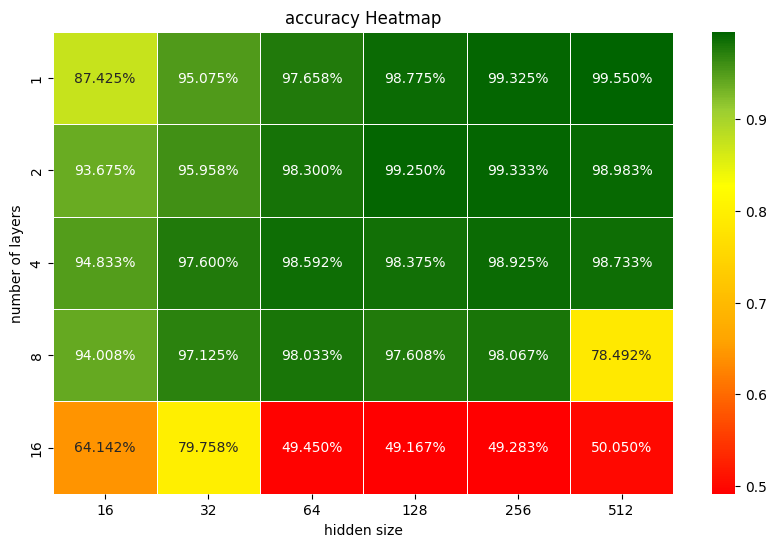

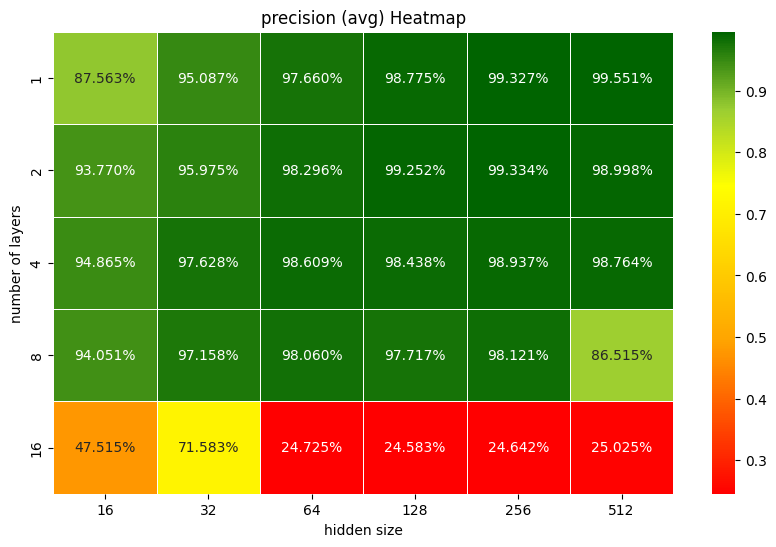

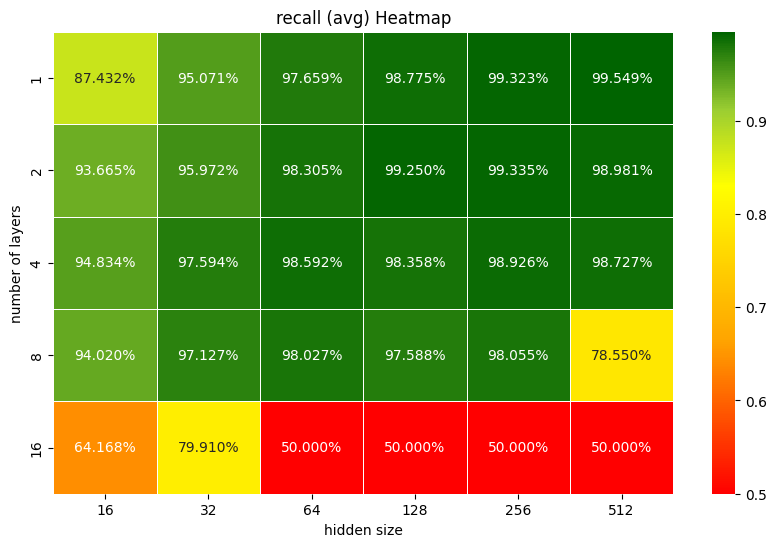

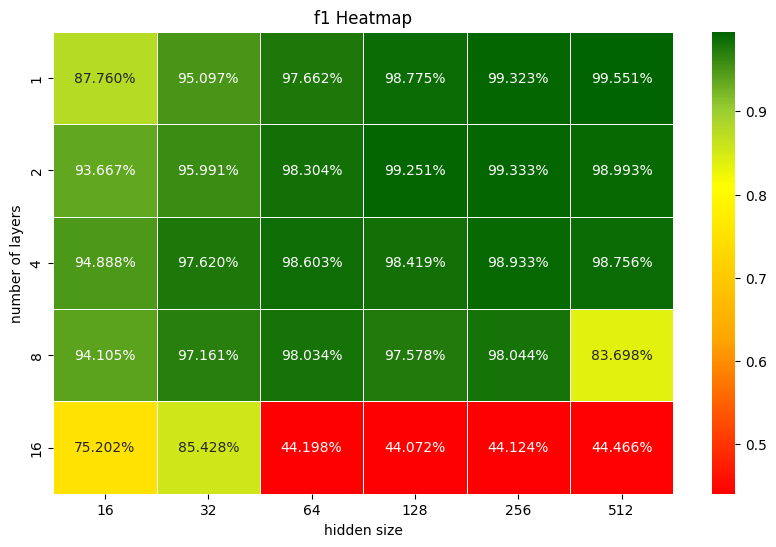

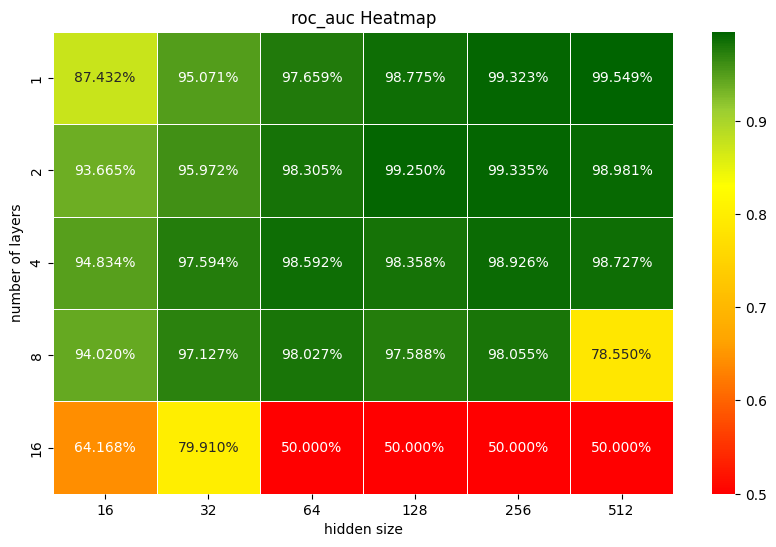

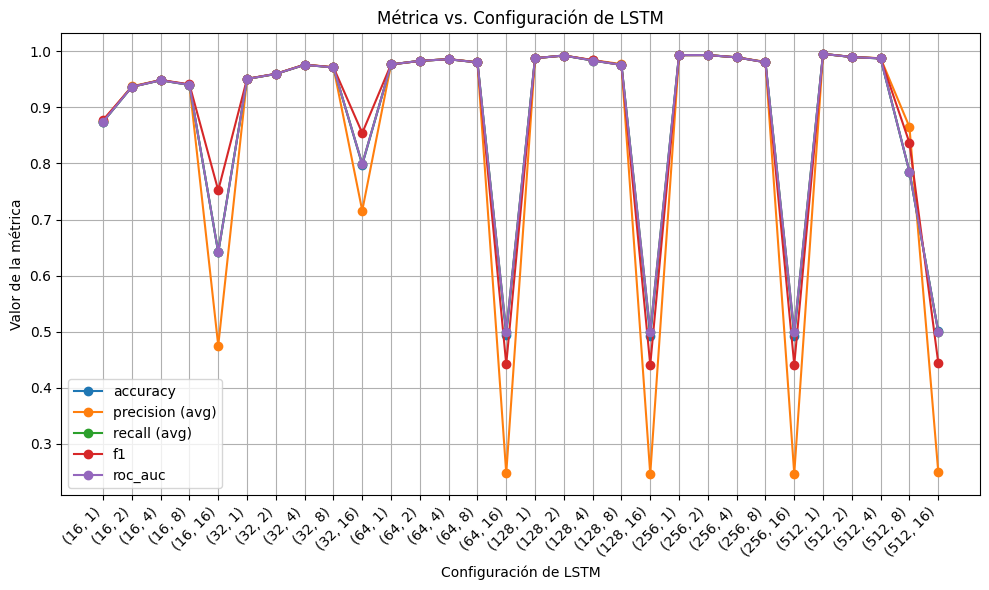

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates
import ast
import re 
import math
import matplotlib.colors as mcolors

# Convert the dictionary to a DataFrame
df = pd.DataFrame(pd.read_csv('lstm_gs_results.csv', index_col=0))

# Use regular expression to find hidden_size and num_layers values
hidden_size_extractor = lambda string_data: re.search(r"'hidden_size': (\d+)", string_data).group(1)
num_layers_extractor = lambda string_data: re.search(r"'num_layers': (\d+)", string_data).group(1)


# Extract hidden_size and num_layers from the keys and use them as names
df.index = df.index.map(lambda x: f"({hidden_size_extractor(x)}, {num_layers_extractor(x)})")

# Heatmap
X = df.index.map(lambda x: ast.literal_eval(x)[0]).unique()
Y = df.index.map(lambda x: ast.literal_eval(x)[1]).unique()
for metric in df:
    image = np.zeros((5, 6), dtype=np.float64)

    # Fill the image with pixel values from the dictionary
    for i, h in df.iterrows():
        x, y = ast.literal_eval(i)
        image[int(math.log2(y)), int(math.log2(x) - 4)] = h[metric]
    
    # colors = [(0, "red"), (0.5, "yellow"), (0.9, "green"), (0.95, "teal"), (0.97, "blue"), (1, "midnightblue")]
    colors = [(0, "red"), (1/3, "orange"), (2/3, "yellow"), (5/6, "yellowgreen"), (1, "darkgreen")]
    cmap_name = 'custom_colormap'
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(image, cmap=custom_cmap, annot=True, fmt=".3%", linewidths=0.5, ax=ax)

    # Customize the plot
    ax.set_xticklabels(X)
    ax.set_yticklabels(Y)
    ax.set_xlabel('hidden size')
    ax.set_ylabel('number of layers')
    ax.set_title(f'{metric} Heatmap')
      
    plt.show()

# Line plots
plt.figure(figsize=(10, 6))
for metric in df.columns:
    plt.plot(df.index, df[metric], marker='o', label=metric)
plt.xlabel('Configuración de LSTM')
plt.ylabel('Valor de la métrica')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.title('Métrica vs. Configuración de LSTM')
plt.tight_layout()
plt.grid(True)
plt.show()



### 4.1 CNN Based

#### 4.1.1 CNN-VAD Implementation

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm as tqdm
from colorama import Style


class CNN_VAD(VoiceActivityDetectorBase):
    """
    Voice Activity Detector (VAD) model for audio classification using CNNs.

    Args:
        input_size (int): Size of the input features.
        output_size (int): Size of the output layer.
        threshold (float, optional): Threshold value for classification (default: 0.5).
        pooling (nn.Module, optional): Pooling function to use (default: nn.MaxPool2d(kernel_size=2, stride=2)).

    Attributes:
        cnn (nn.Sequential): Sequential CNN layers.
        fc (nn.Linear): Fully connected layer for classification.
        threshold (float): Threshold value for classification.
        pooling (nn.Module): Pooling layer.

    Methods:
        forward(x): Forward pass of the model.
        train_model(audio_dataloader, label_dataloader, criterion, optimizer, epochs, scheduler=None):
            Train the model.
        predict_prob(audio_dataloader): Predict probabilities of audio samples.
        predict_class(audio_dataloader): Predict classes (0 or 1) based on probabilities.
        pred_from_prob(probabilities): Convert probabilities to classes based on the threshold.
        eval_model(audio_dataloader, label_dataloader): Evaluate the model on the provided data.
    """

    def __init__(
        self,
        output_size,
        pooling,
        out_channels,
        kernel_size,
        stride=-1,
        threshold=0.5,
    ):
        super(CNN_VAD, self).__init__(threshold)
        if stride == -1:
            stride = kernel_size
            
        # Define the CNN and fully connected layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, out_channels, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
            pooling
        )
        self.fc = nn.Linear(out_channels, output_size)


    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            output_prob (torch.Tensor): Predicted probabilities of shape (batch_size, output_size).
        """
        batch_size = x.size(0)
        height = x.size(1)
        width = x.size(2)
        x = x.view((batch_size, 1, height, width))
        x = self.cnn(x)
        x = x.view(batch_size, -1)
        output = self.fc(x)
        
        return output.flatten()

    def save_model(self, filepath):
        """
        Save the model to a file.

        Args:
            filepath (str): Path to the file where the model will be saved.
        """
        torch.save({
            'state_dict': self.state_dict(),
            'hyperparams': {
                'input_size': self.cnn[0].in_channels,
                'output_size': self.fc.out_features,
                'threshold': self.threshold
            }
        }, filepath)

    @classmethod
    def load_model(cls, filepath):
        """
        Load the model from a file.

        Args:
            filepath (str): Path to the file where the model is saved.

        Returns:
            CNN_VAD: Loaded model.
        """
        checkpoint = torch.load(filepath)
        model = cls(
            checkpoint['hyperparams']['input_size'],
            checkpoint['hyperparams']['output_size'],
            checkpoint['hyperparams']['threshold']
        )
        model.load_state_dict(checkpoint['state_dict'])
        return model


#### 4.1.2 VAD Wrapper (To use with Grid Search)

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader

BATCH_SIZE = 16

class CNN_VAD_Wrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, output_size, pooling, out_channels, kernel_size, stride=-1, threshold=0.5,
                 lr=0.0001, criterion=None, optimizer=None, epochs=None, scheduler=None):
        """
        Wrapper class for CNN-based Voice Activity Detector (VAD) model.

        Args:
            output_size (int): Size of the output layer.
            pooling (nn.Module): Pooling function to use (e.g., nn.MaxPool2d(kernel_size=2, stride=2)).
            out_channels (int): Number of output channels for the CNN.
            kernel_size (int): Kernel size for the CNN.
            stride (int, optional): Stride for the CNN (default: -1, which sets stride=kernel_size).
            threshold (float): Threshold value for class prediction.
            criterion: Loss criterion for training the model.
            optimizer: Optimizer for training the model.
            epochs (int): Number of epochs for training the model.
            scheduler: Learning rate scheduler.
        """
        self.model = CNN_VAD(output_size, pooling, out_channels, kernel_size, stride, threshold)
        self.model = self.model.to(dtype=torch.double)
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.scheduler = scheduler
        self.lr = lr
        self.output_size = output_size
        self.pooling = pooling
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.threshold = threshold

    def fit(self, X, y, verbose=True):
        """
        Fit the CNN-based VAD model to the provided data.

        Args:
            X (torch.Tensor): Input audio data.
            y (torch.Tensor): Label data.

        Returns:
            self: Fitted estimator.
        """
        # Assuming X is the audio data and y is the label data
        train_audio_loader = DataLoader(X, batch_size=BATCH_SIZE)
        train_label_loader = DataLoader(y, batch_size=BATCH_SIZE)
        self.model.train_model(train_audio_loader, train_label_loader, self.criterion, self.optimizer, self.epochs,
                               self.lr, self.scheduler, verbose)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probabilities of audio samples.

        Args:
            X (torch.Tensor): Input audio data.

        Returns:
            torch.Tensor: Predicted probabilities of shape (num_samples, output_size).
        """
        # Assuming X is the audio data
        test_audio_loader = DataLoader(X, batch_size=BATCH_SIZE)
        return self.model.predict_prob(test_audio_loader)
    
    def predict(self, X):
        """
        Predict the classes of audio samples.

        Args:
            X (torch.Tensor): Input audio data.

        Returns:
            torch.Tensor: Predicted classes of shape (num_samples,).
        """
        # Assuming X is the audio data
        test_audio_loader = DataLoader(X, batch_size=BATCH_SIZE)
        return self.model.predict_class(test_audio_loader)

    def score(self, X, y):
        """
        Calculate the accuracy of the CNN-based VAD model on the provided data.

        Args:
            X (torch.Tensor): Input audio data.
            y (torch.Tensor): Label data.

        Returns:
            float: Accuracy of the model on the provided data.
        """
        # Assuming X is the audio data and y is the label data
        test_audio_loader = DataLoader(X, batch_size=BATCH_SIZE)
        test_label_loader = DataLoader(y, batch_size=BATCH_SIZE)
        accuracy = self.model.eval_model(test_audio_loader, test_label_loader)
        return accuracy
    
    def save(self, filepath):
        """
        Save the CNN-based VAD model to a file.

        Args:
            filepath (str): Path to the file where the model will be saved.
        """
        self.model.save_model(filepath)

    @classmethod
    def load(cls, filepath):
        """
        Load the CNN-based VAD model from a file.

        Args:
            filepath (str): Path to the file where the model is saved.

        Returns:
            CNN_VAD_Wrapper: Loaded model.
        """
        checkpoint = torch.load(filepath)
        model = CNN_VAD(
            checkpoint['hyperparams']['output_size'],
            checkpoint['pooling'],
            checkpoint['out_channels'],
            checkpoint['kernel_size'],
            checkpoint['stride'],
            checkpoint['hyperparams']['threshold']
        )
        model.load_state_dict(checkpoint['state_dict'])
        wrapper = cls(
            checkpoint['hyperparams']['output_size'],
            checkpoint['pooling'],
            checkpoint['out_channels'],
            checkpoint['kernel_size'],
            checkpoint['stride'],
            checkpoint['hyperparams']['threshold'],
            criterion=None,
            optimizer=None,
            epochs=None,
            scheduler=None
        )
        wrapper.model = model
        return wrapper

#### 3.1.3 Example of ***CNN*** Based VAD  

##### Definition of the Grouping agg. function

In [7]:
import torch
import torch.nn as nn

class GroupingPool2d(torch.nn.Module):
    def __init__(self, kernel_size=None, stride=None, padding=0):
        super(GroupingPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, x):
        x_max, _ = torch.max(x, dim=3, keepdim=True)
        x_min, _ = torch.min(x, dim=3, keepdim=True)

        # Create a mask where both x_max and x_min are non-zero
        mask = (x_max != x_min)
        
        # Initialize normalized tensor with zeros
        x_norm = torch.zeros_like(x)
        
        # Divide only where both x_max and x_min are non-zero
        x_norm[mask.squeeze(3)] = (x[mask.squeeze(3)] - x_min[mask].view(-1, 1)) / (x_max[mask].view(-1, 1) - x_min[mask].view(-1, 1))
        
        x_out = 1 - torch.prod(1 - x_norm, dim=3)
        x_out = x_out * (x_max.squeeze(3) - x_min.squeeze(3)) + x_min.squeeze(3)
        
        return x_out

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from Preprocessing import *
import pandas as pd

N = 15000
SHUFFLE = False

positive_class_label = 'speech'
negative_class_label = 'non-speech'

csv_file = 'spectrogram_dataset_augmented_balanced.csv'
preprocess_function = preprocess_audio_spectrogram


data = pd.read_csv(csv_file, index_col=None)
df_speech = data[data['label'] == 'speech'].sample(n=N//2, random_state=42)
df_non_speech = data[data['label'] == 'non-speech'].sample(n=N//2, random_state=42)

data = pd.concat([df_speech, df_non_speech], ignore_index=True)

# Split the DataFrame into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


train_audio_dataset = AudioDataset(train_data, preprocess_function)
test_audio_dataset = AudioDataset(test_data, preprocess_function)

train_label_dataset = LabelDataset(train_data, positive_class_label)
test_label_dataset = LabelDataset(test_data, positive_class_label)

# Create data loaders for training, validation, and test sets
batch_size = 16
train_audio_loader = DataLoader(train_audio_dataset, batch_size=batch_size, shuffle=SHUFFLE)
test_audio_loader = DataLoader(test_audio_dataset, batch_size=batch_size, shuffle=SHUFFLE)

train_label_loader = DataLoader(train_label_dataset, batch_size=batch_size, shuffle=SHUFFLE)
test_label_loader = DataLoader(test_label_dataset, batch_size=batch_size, shuffle=SHUFFLE)


example = train_audio_dataset[0]
plt.imshow(example, cmap='hot', aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')  # Barra de color opcional
plt.xlabel('Cuadros de Tiempo')
plt.ylabel('Bandas de Frecuencia')
plt.title('example')
plt.show()
print(example.shape)

input_height = example.shape[0]
input_width = example.shape[1]
learning_rate = 1e-4

print('dataset_size: ', len(train_audio_dataset))


output_size = 1  # 1 output for binary classification (voice or non-voice)
k = input_height
pooling = GroupingPool2d()

out_channels = 4

pooling = nn.MaxPool2d(kernel_size=(1, input_width))
out_channels = 1
kernel_size = (input_height, 1)
stride = (input_height, 1)


model = CNN_VAD(output_size, pooling, out_channels, kernel_size, stride)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
scheduler = lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 1


model = model.to(dtype=torch.double)
model.train_model(train_audio_loader, train_label_loader, criterion, optimizer, num_epochs, learning_rate=learning_rate, scheduler=scheduler)
acc = model.eval_model(test_audio_loader, test_label_loader)
print(f'\n\nTest acc: {acc:4.3%}\n\n')
pred = model.predict_class(test_audio_loader)
print(pred, type(pred))
my_acc = 0
test_labels = np.array(test_data['label'] == positive_class_label)
test_labels = test_labels.astype(np.int32)
test_files = test_data['file_path']
for file, true_label, pred_label in zip(test_files, test_labels, pred):
    print(f'{file} ({true_label}):  {pred_label}')
    my_acc += (true_label == pred_label)


from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the confusion matrix
cm = confusion_matrix(test_labels, pred)

# Plot the confusion matrix
label_names = ["non-speech", "speech"]
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(label_names)
ax.yaxis.set_ticklabels(label_names)

plt.show()

# Compute precision and recall
precision = precision_score(test_labels, pred, average=None)
recall = recall_score(test_labels, pred, average=None)

# Print precision and recall for each class
for i, label in enumerate(label_names):
    print(f"{label} Precision: {precision[i]:.2%}")
    print(f"{label} Recall: {recall[i]:.2%}")


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn as nn

from torch import optim as opt
from torch.optim import lr_scheduler as sch

from sklearn.model_selection import train_test_split
from Preprocessing import *
import pandas as pd



N = 15000

positive_class_label = 'speech'
negative_class_label = 'non-speech'

csv_file = 'spectrogram_dataset_augmented_balanced.csv'
preprocess_function = preprocess_audio_spectrogram_rot

data = pd.read_csv(csv_file, index_col=None)
# N = data.shape[0]
df_speech = data[data['label'] == 'speech'].sample(n=N//2, random_state=42)
df_non_speech = data[data['label'] == 'non-speech'].sample(n=N//2, random_state=42)

data = pd.concat([df_speech, df_non_speech], ignore_index=True)

# Split the DataFrame into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_audio_dataset = AudioDataset(train_data, preprocess_function)
# valid_dataset = AudioChunkDataset(val_data, positive_class_label, negative_class_label, preprocess_function)
test_audio_dataset = AudioDataset(test_data, preprocess_function)

train_label_dataset = LabelDataset(train_data, positive_class_label)
# valid_dataset = LabelDataset(val_data, positive_class_label, negative_class_label, preprocess_function)
test_label_dataset = LabelDataset(test_data, positive_class_label)


example = train_audio_dataset[0]
print(example, example.shape)
input_size = example.shape[1]

print('dataset_size: ', len(train_audio_dataset))
print('input_size: ', input_size)

input_height = example.shape[0]
input_width = example.shape[1]

# un-searchable parameters
output_size = 1  # 1 output for binary classification (voice or non-voice)


scheduler = lambda optimizer: sch.StepLR(optimizer, step_size=5, gamma=0.1)
optimizer = opt.Adam
criterion = nn.BCEWithLogitsLoss()
lr = 1e-4
epochs = 5
out_channel_list = [16, 32, 64, 128, 512]

param_grid = [
    {'output_size': [output_size],
    'pooling': [nn.MaxPool2d(kernel_size=(1, (input_width - 2) // 2 + 1)), 
                GroupingPool2d()],
    'out_channels': out_channel_list,
    'kernel_size': [(input_height, 2)],
    'stride': [(input_height, 2)],
    'lr': [lr],
    'criterion': [criterion],
    'optimizer': [optimizer],
    'epochs': [epochs],
    'scheduler': [scheduler]},

    {'output_size': [output_size],
    'pooling': [nn.MaxPool2d(kernel_size=(1, input_width - 2 + 1)), 
                GroupingPool2d()],
    'out_channels': out_channel_list,
    'kernel_size': [(input_height, 2)],
    'stride': [(input_height, 1)],
    'lr': [lr],
    'criterion': [criterion],
    'optimizer': [optimizer],
    'epochs': [epochs],
    'scheduler': [scheduler]},
]


# Create an instance of the wrapper with the lambda functions
wrapper = CNN_VAD_Wrapper

CV = 3
jobs = -1

# Create the GridSearchCV object
grid_search = GridSearchCV(wrapper, param_grid)

X_train = train_audio_dataset
y_train = train_label_dataset

average_precision = lambda y_true, y_pred: (precision_score(y_true, y_pred, pos_label=0) + precision_score(y_true, y_pred, pos_label=1)) / 2
average_recall = lambda y_true, y_pred: (recall_score(y_true, y_pred, pos_label=0) + recall_score(y_true, y_pred, pos_label=1)) / 2

# Fit the grid search to the data
grid_search.fit(X_train, y_train, cv=CV, n_jobs=jobs, scoring={'accuracy': (accuracy_score, 'max'),
                                                               'precision (avg)': (average_precision, 'max'),
                                                               'recall (avg)': (average_recall, 'max'),
                                                               'f1': (f1_score, 'max'),
                                                               'roc_auc': (roc_auc_score, 'max')},
                                                                verbose=False)

# Get the all the scores (by the used parameters)
sc = grid_search.getScores()
for x in grid_search.getScores():
    print('parameters: ', x, '->', '\n\tscore:', sc[x])


# Get the best models and its scores
bm = grid_search.getBestModel()
for x in grid_search.getBestModel():
    print('metric: ', x, '->', bm[x]['score'], '\n\tmodel:', bm[x]['model'], end='\n\n')



##### Analyzing the results

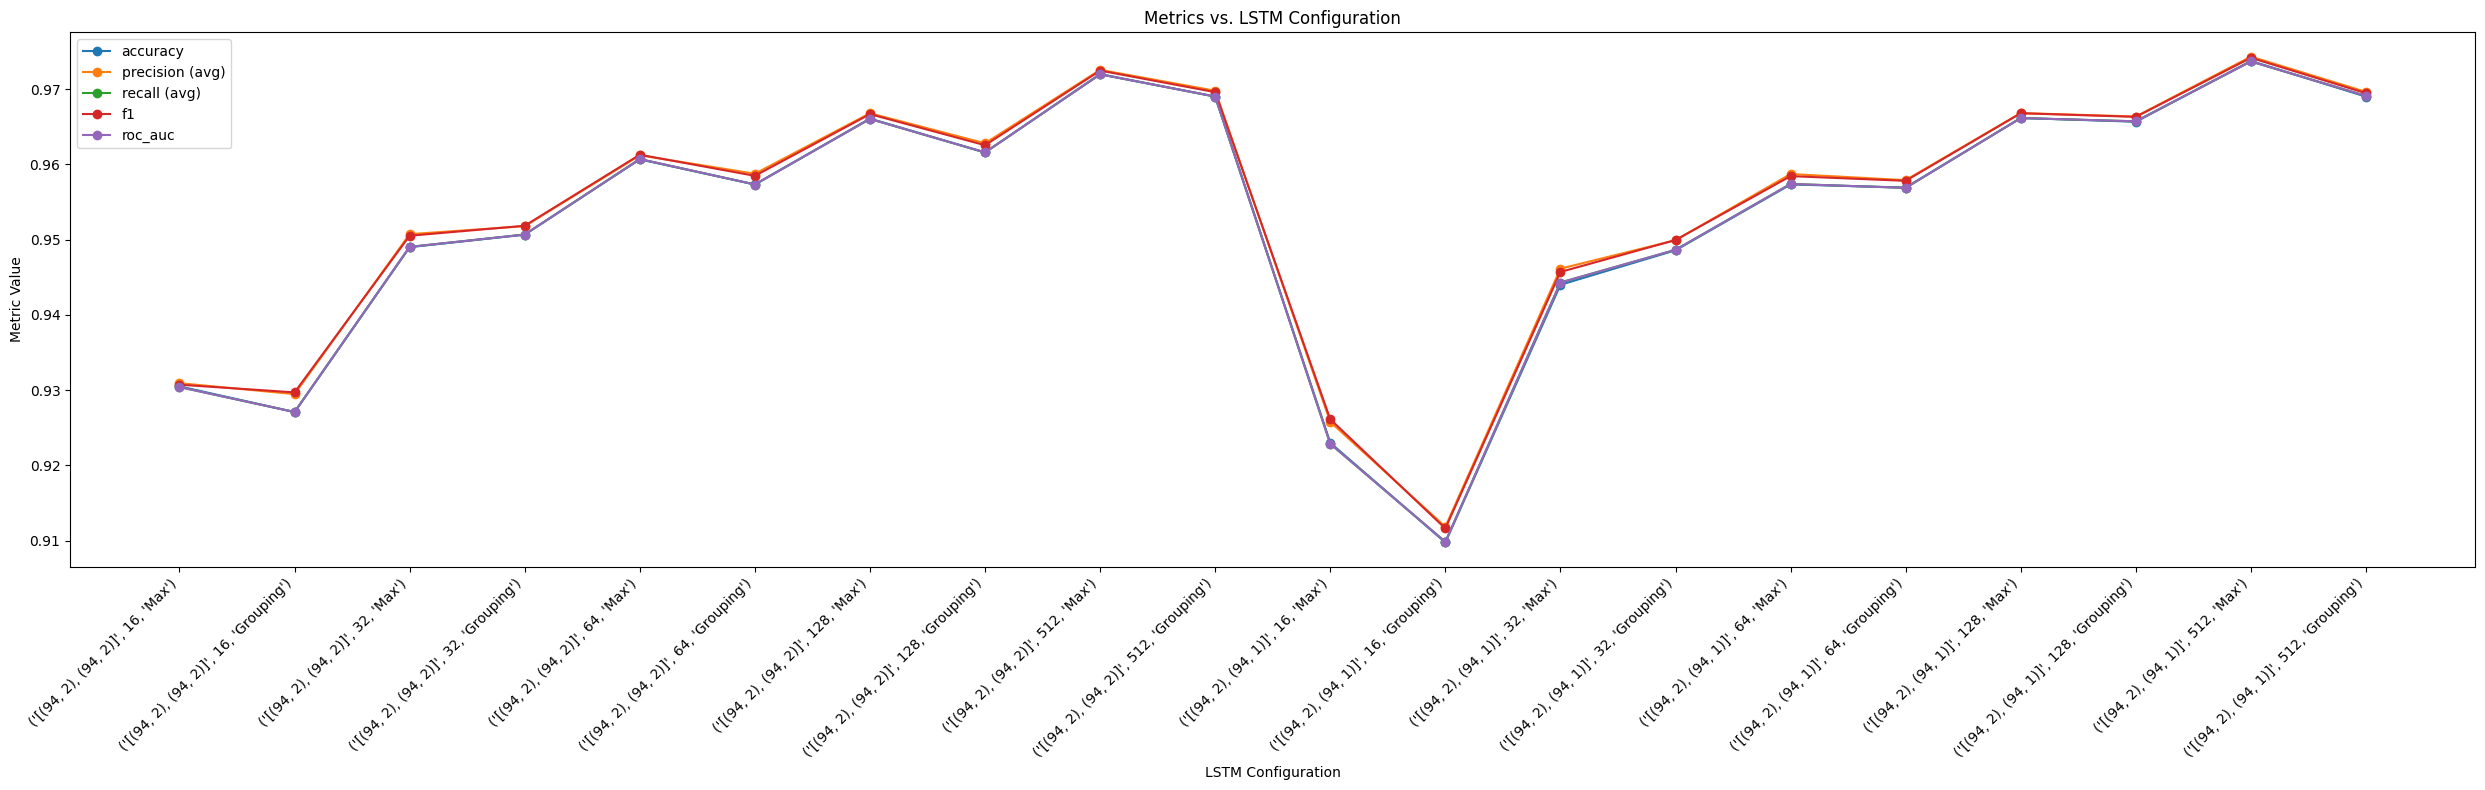

,accuracy,precision (avg),recall (avg),f1,roc_auc,architecture,channels,aggregation
0,0.930500,0.930929,0.930406,0.930721,0.930406,"[(94, 2), (94, 2)]",16,Max
1,0.927083,0.929467,0.927087,0.929700,0.927087,"[(94, 2), (94, 2)]",16,Grouping
2,0.949000,0.950726,0.949036,0.950518,0.949036,"[(94, 2), (94, 2)]",32,Max
3,0.950667,0.951789,0.950674,0.951844,0.950674,"[(94, 2), (94, 2)]",32,Grouping
4,0.960667,0.961204,0.960708,0.961285,0.960708,"[(94, 2), (94, 2)]",64,Max
5,0.957333,0.958759,0.957325,0.958477,0.957325,"[(94, 2), (94, 2)]",64,Grouping
6,0.966083,0.966793,0.966044,0.966679,0.966044,"[(94, 2), (94, 2)]",128,Max
7,0.961583,0.962805,0.961589,0.962547,0.961589,"[(94, 2), (94, 2)]",128,Grouping
8,0.972000,0.972561,0.971969,0.972463,0.971969,"[(94, 2), (94, 2)]",512,Max
9,0.969000,0.969790,0.969021,0.969599,0.969021,"[(94, 2), (94, 2)]",512,Grouping


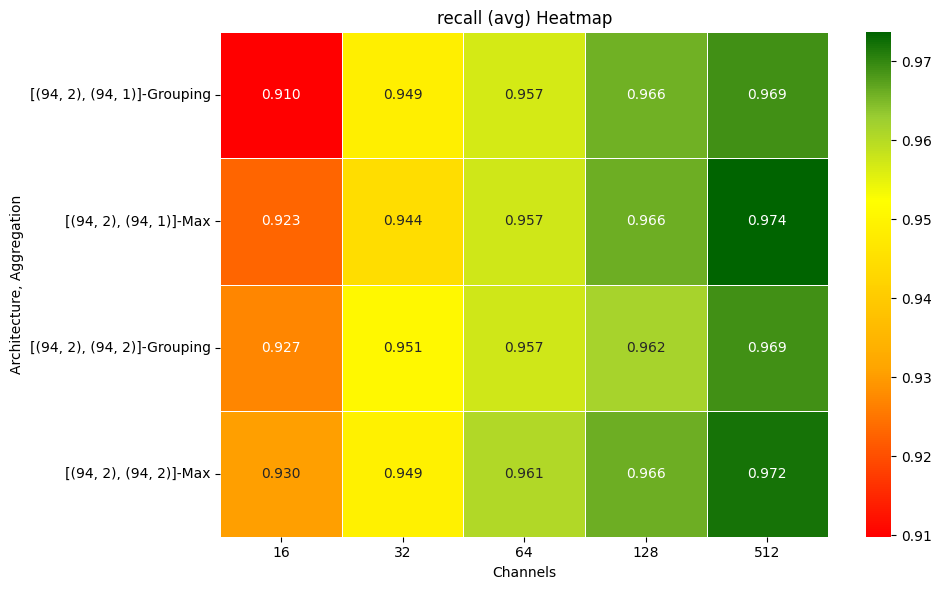

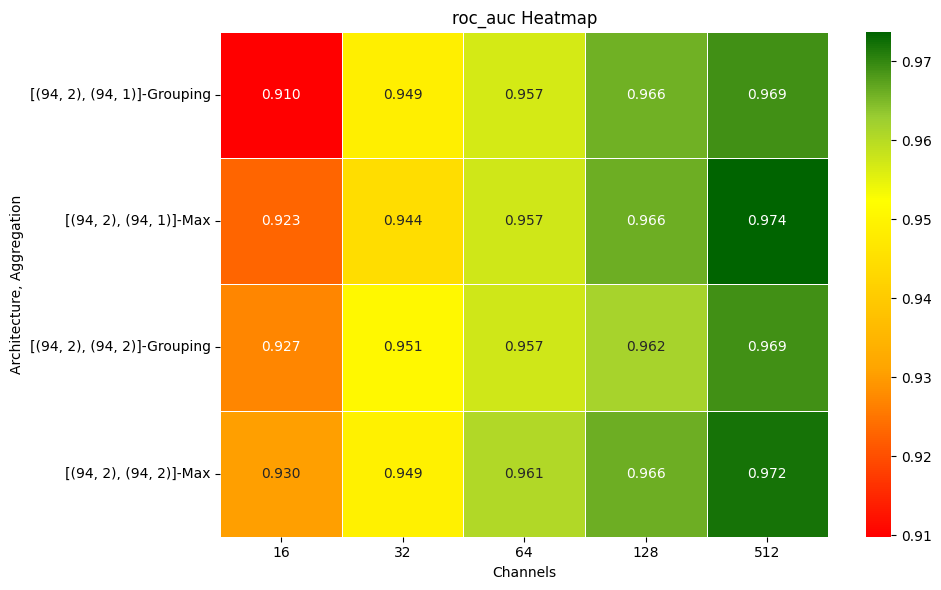

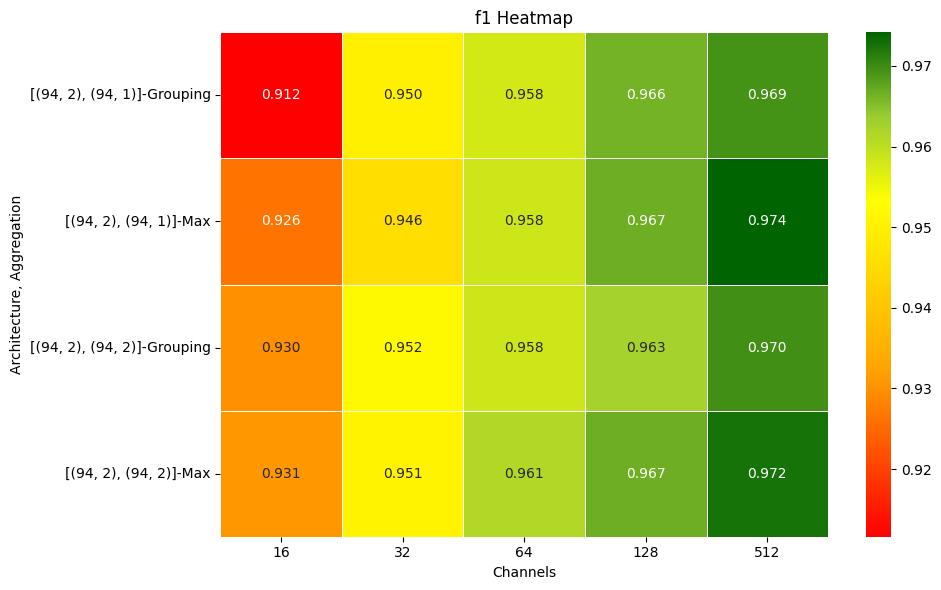

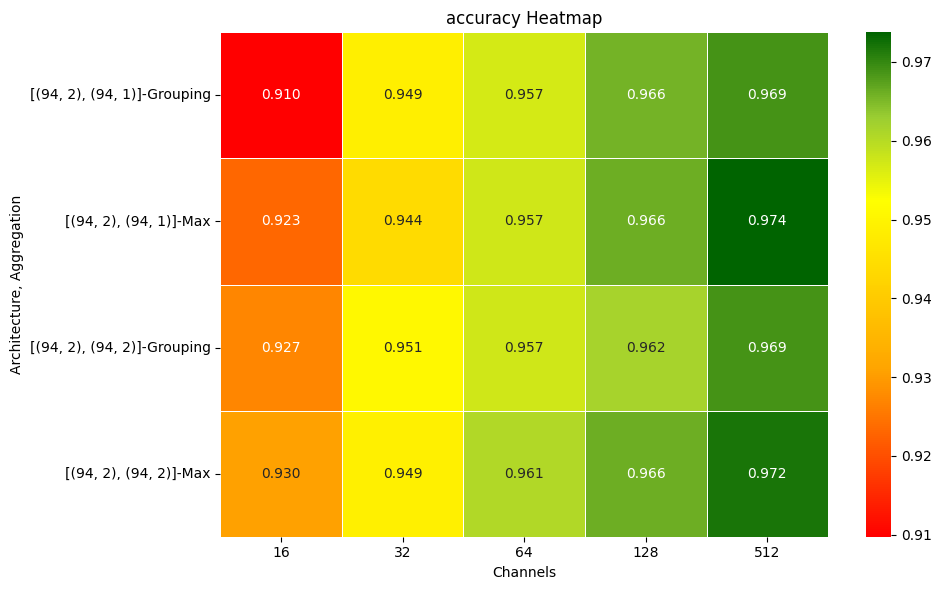

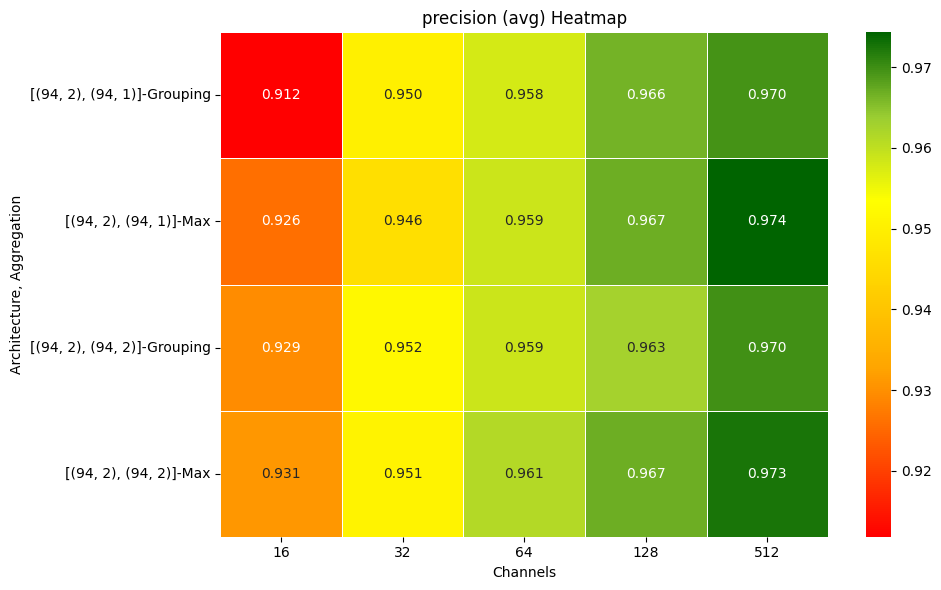

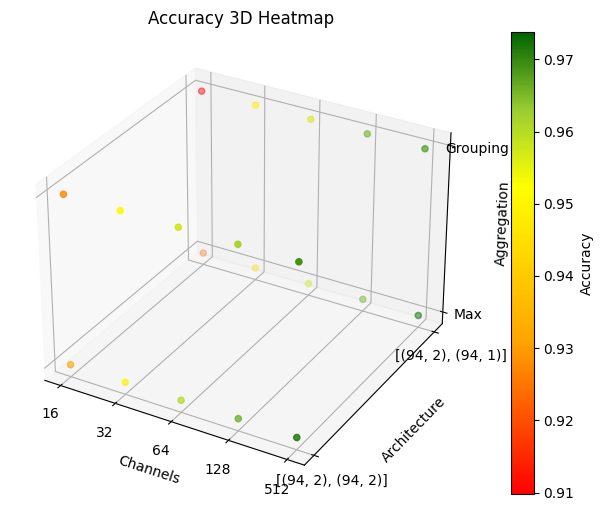

TypeError: 'int' object is not subscriptable

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates
import ast
import re 
import math
import matplotlib.colors as mcolors

# Convert the dictionary to a DataFrame
df = pd.DataFrame(sc).transpose()
# df.to_csv('cnn_gs_results2.csv')

# Use regular expression to find hidden_size and num_layers values
kernel_size_extractor = lambda string_data: re.search(r"'kernel_size': \((\d+, \d+)\)", string_data).group(1)
stride_extractor = lambda string_data: re.search(r"'stride': \((\d+, \d+)\)", string_data).group(1)
pooling_extractor = lambda string_data: re.search(r"'pooling': (\w+)P", string_data).group(1)
out_channels_extractor = lambda string_data: re.search(r"'out_channels': (\d+)", string_data).group(1)


# Extract hidden_size and num_layers from the keys and use them as names
df.index = df.index.map(lambda x: f"('[({kernel_size_extractor(x)}), ({stride_extractor(x)})]', {out_channels_extractor(x)}, '{pooling_extractor(x)}')")


# Line plots
plt.figure(figsize=(25, 8))
for metric in df.columns:
    plt.plot(df.index, df[metric], marker='o', label=metric)
plt.xlabel('LSTM Configuration')
plt.ylabel('Metric Value')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.title('Metrics vs. LSTM Configuration')
plt.tight_layout()
plt.show()


df.reset_index(inplace=True)

# Create new columns from the existing index
df[['architecture', 'channels', 'aggregation']] = df['index'].apply(lambda x: pd.Series(eval(x)))

# Drop the original index column
df.drop('index', axis=1, inplace=True)
display(df)


import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named 'results_df' with columns: 'architecture', 'aggregation', 'channels', and 'accuracy'

# Group the data by architecture and aggregation function
grouped_df = df.groupby(['architecture', 'aggregation'])

display(grouped_df)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

metrics = set(df.columns) - set(['architecture', 'aggregation', 'channels'])

for metric in metrics:
    # Group the data by 'architecture', 'aggregation', and 'channels', and calculate the mean accuracy
    grouped_df = df.groupby(['architecture', 'aggregation', 'channels']).mean()[metric].reset_index()

    # Create a pivot table to reshape the data for the heatmap
    heatmap_df = grouped_df.pivot(index=['architecture', 'aggregation'], columns='channels', values=metric)

    # Create the heatmap

    colors = [(0, "red"), (1/3, "orange"), (2/3, "yellow"), (5/6, "yellowgreen"), (1, "darkgreen")]
    cmap_name = 'custom_colormap'
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(heatmap_df, cmap=custom_cmap, annot=True, fmt=".3%", linewidths=0.5, ax=ax)

    # Customize the plot
    ax.set_xlabel('Channels')
    ax.set_ylabel('Architecture, Aggregation')
    ax.set_title(f'{metric} Heatmap')

    plt.tight_layout()
    plt.show()




import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have the DataFrame named 'df' with columns: 'architecture', 'aggregation', 'channels', and 'accuracy'

# Create a mapping of unique tuples in 'architecture' column to unique integer values
architecture_map = {arch: i for i, arch in enumerate(df['architecture'].unique())}
# Create a new column 'architecture_id' with the mapped integer values
df['architecture_id'] = df['architecture'].map(architecture_map)

# Create a mapping of unique values in 'aggregation' column to unique integer values
aggregation_map = {agg: i for i, agg in enumerate(df['aggregation'].unique())}
# Create a new column 'aggregation_id' with the mapped integer values
df['aggregation_id'] = df['aggregation'].map(aggregation_map)

# Create a mapping of unique values in 'channels' column to unique integer values
channels_map = {ch: i for i, ch in enumerate(df['channels'].unique())}
# Create a new column 'channels_id' with the mapped integer values
df['channels_id'] = df['channels'].map(channels_map)

# Create a 3D figure
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D heatmap
x = df['channels_id']  # Use the new 'channels_id' column
y = df['architecture_id']  # Use the new 'architecture_id' column
z = df['aggregation_id']  # Use the new 'aggregation_id' column
c = df['accuracy']
ax.scatter(x, y, z, c=c, cmap=custom_cmap)

# Customize the plot
ax.set_xlabel('Channels')
ax.set_ylabel('Architecture')
ax.set_zlabel('Aggregation')
ax.set_title('Accuracy 3D Heatmap')

# Show the colorbar
cbar = plt.colorbar(ax.collections[0])
cbar.set_label('Accuracy')

# Use the mappings to show the actual labels on the axes
ax.set_xticks(list(channels_map.values()))
ax.set_xticklabels(list(channels_map.keys()))
ax.set_yticks(list(architecture_map.values()))
ax.set_yticklabels(list(architecture_map.keys()))
ax.set_zticks(list(aggregation_map.values()))
ax.set_zticklabels(list(aggregation_map.keys()))

plt.show()











# Heatmap
X = df.index.map(lambda x: x['channels']).unique()
Y = df.index.map(lambda x: (x['architecture'], x['aggregation'])).unique()



for metric in df:
    image = np.zeros((5, 6), dtype=np.float64)

    # Fill the image with pixel values from the dictionary
    for i, h in df.iterrows():
        x, y = ast.literal_eval(i)
        image[int(math.log2(y)), int(math.log2(x) - 4)] = h[metric]
    
    # colors = [(0, "red"), (0.5, "yellow"), (0.9, "green"), (0.95, "teal"), (0.97, "blue"), (1, "midnightblue")]
    colors = [(0, "red"), (1/3, "orange"), (2/3, "yellow"), (5/6, "yellowgreen"), (1, "darkgreen")]
    cmap_name = 'custom_colormap'
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

    plt.figure(figsize=(10, 6))
    heatmap = plt.imshow(image[:-1][:], cmap=custom_cmap, interpolation='nearest', aspect='auto')
    plt.colorbar(heatmap, label=metric)
    plt.xticks(np.arange(len(X)), X, rotation=45, ha='right')
    plt.yticks(np.arange(len(Y[:-1])), Y[:-1])
    plt.xlabel('hidden size')
    plt.ylabel('number of layers')
    for i in range(4):
        for j in range(6):
            # Place the text at the center of each cell
            plt.annotate(f'{image[i, j]:.2%}', xy=(j, i),
                        ha='center', va='center', color='black')
    plt.title('Grid Search Results Heatmap')
    plt.tight_layout()
    plt.show()


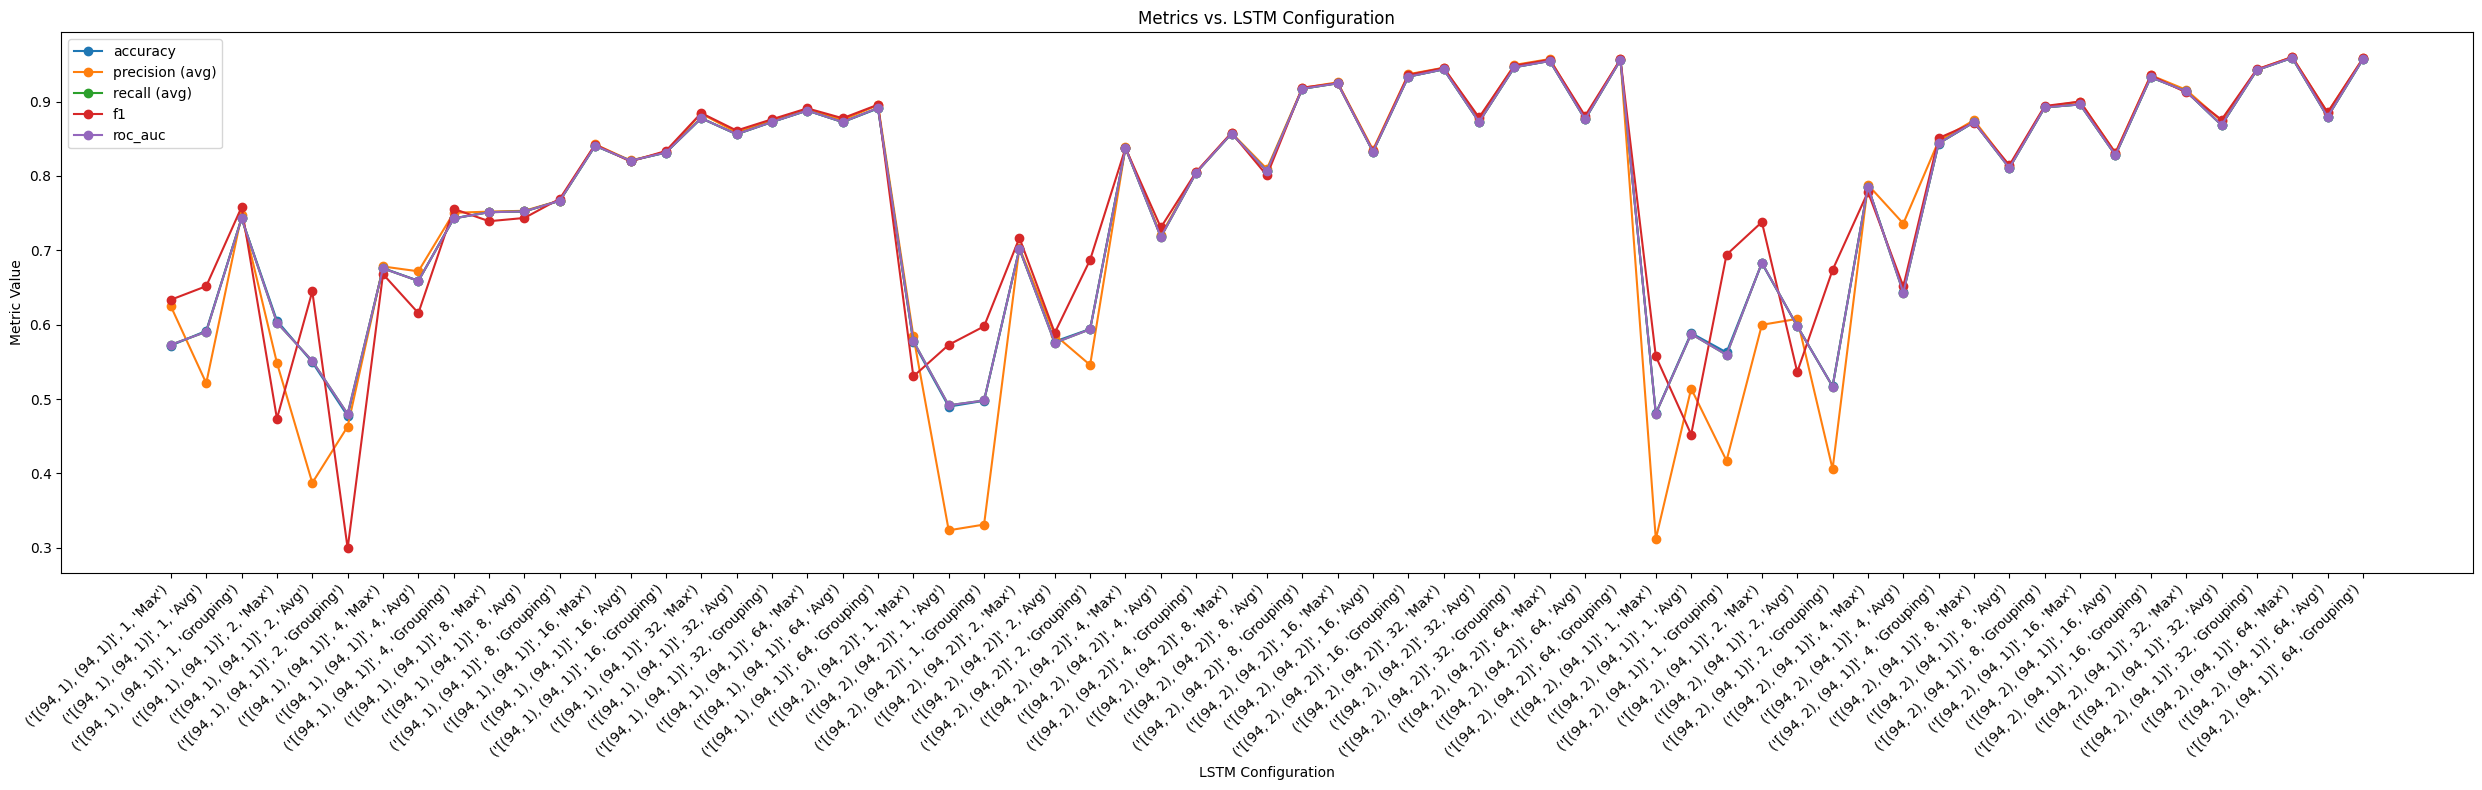

,accuracy,precision (avg),recall (avg),f1,roc_auc,architecture,channels,aggregation
0,0.571917,0.624721,0.573123,0.633591,0.573123,"[(94, 1), (94, 1)]",1,Max
1,0.591750,0.521407,0.590503,0.651827,0.590503,"[(94, 1), (94, 1)]",1,Avg
2,0.743083,0.747490,0.743065,0.758158,0.743065,"[(94, 1), (94, 1)]",1,Grp
3,0.605417,0.548613,0.602738,0.473666,0.602738,"[(94, 1), (94, 1)]",2,Max
4,0.549500,0.387345,0.551276,0.644795,0.551276,"[(94, 1), (94, 1)]",2,Avg
...,...,...,...,...,...,...,...,...
58,0.868417,0.874045,0.868491,0.875590,0.868491,"[(94, 2), (94, 1)]",32,Avg
59,0.942417,0.942992,0.942416,0.943481,0.942416,"[(94, 2), (94, 1)]",32,Grp
60,0.958833,0.960124,0.958870,0.959885,0.958870,"[(94, 2), (94, 1)]",64,Max
61,0.879667,0.885148,0.879452,0.885442,0.879452,"[(94, 2), (94, 1)]",64,Avg


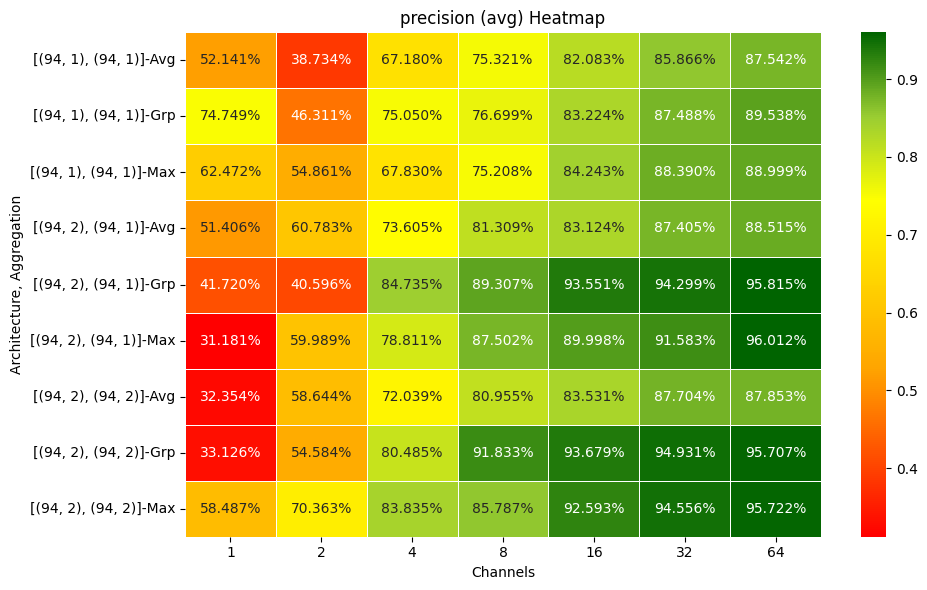

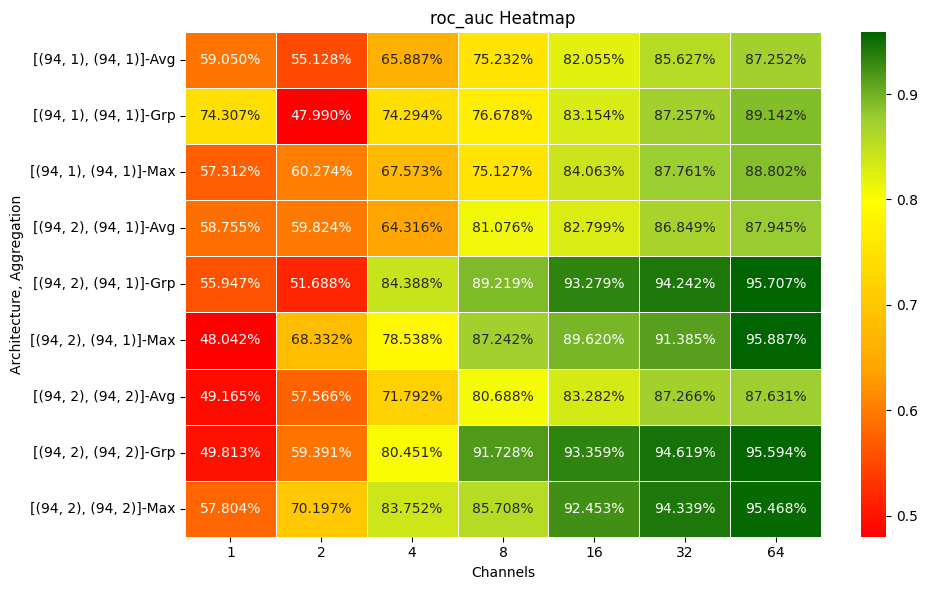

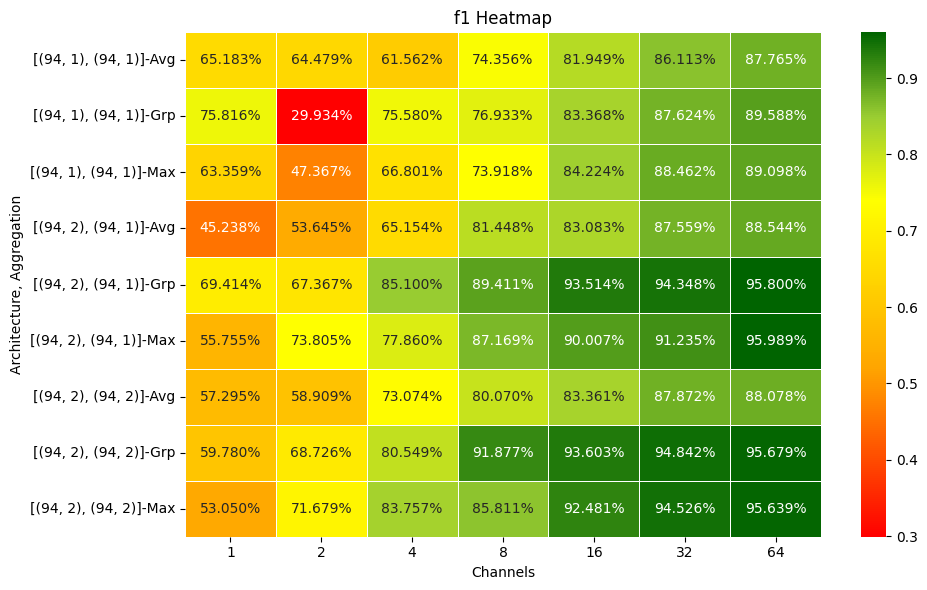

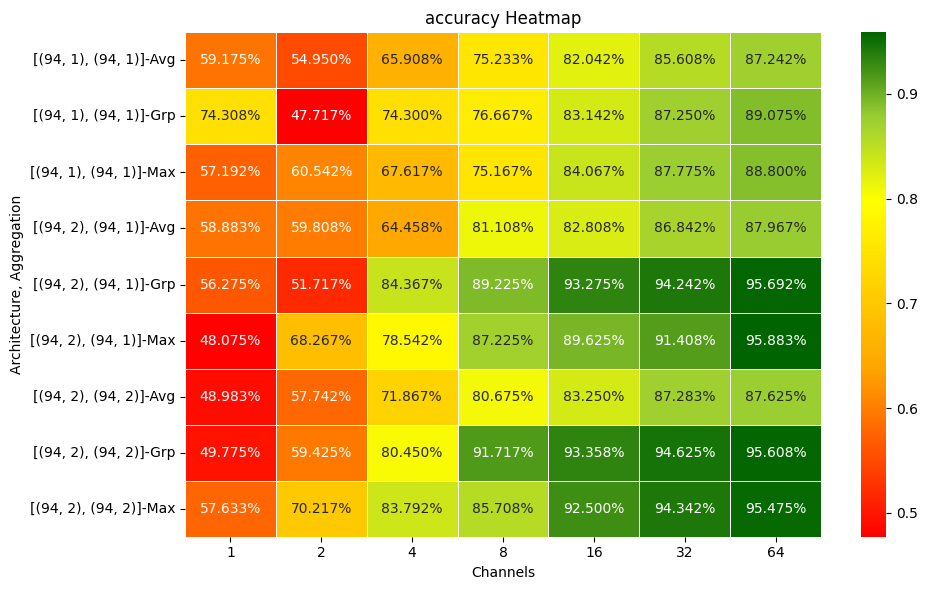

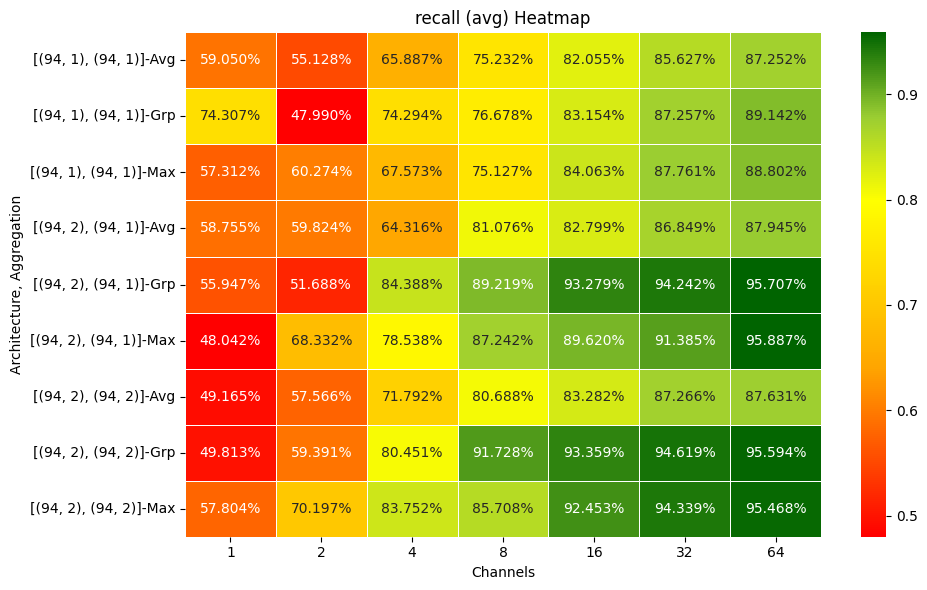

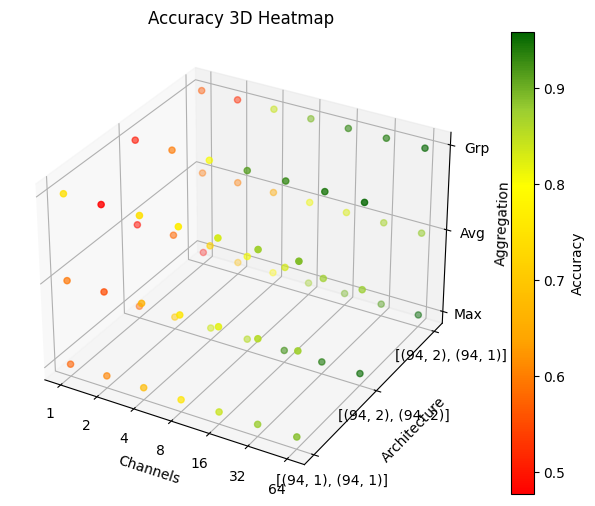

TypeError: 'int' object is not subscriptable

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates
import ast
import re 
import math
import matplotlib.colors as mcolors

# Convert the dictionary to a DataFrame
df = pd.DataFrame(pd.read_csv('cnn_gs_results1.csv', index_col=0))

# Use regular expression to find hidden_size and num_layers values
kernel_size_extractor = lambda string_data: re.search(r"'kernel_size': \((\d+, \d+)\)", string_data).group(1)
stride_extractor = lambda string_data: re.search(r"'stride': \((\d+, \d+)\)", string_data).group(1)
pooling_extractor = lambda string_data: re.search(r"'pooling': (\w+)P", string_data).group(1)
out_channels_extractor = lambda string_data: re.search(r"'out_channels': (\d+)", string_data).group(1)


# Extract hidden_size and num_layers from the keys and use them as names
df.index = df.index.map(lambda x: f"('[({kernel_size_extractor(x)}), ({stride_extractor(x)})]', {out_channels_extractor(x)}, '{pooling_extractor(x)}')")


'''-----------------------------------------------------------'''
# Line plots
plt.figure(figsize=(25, 8))
for metric in df.columns:
    plt.plot(df.index, df[metric], marker='o', label=metric)
plt.xlabel('LSTM Configuration')
plt.ylabel('Metric Value')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.title('Metrics vs. LSTM Configuration')
plt.tight_layout()
plt.show()


df.reset_index(inplace=True)

# Create new columns from the existing index
df[['architecture', 'channels', 'aggregation']] = df['index'].apply(lambda x: pd.Series(eval(x)))

# Drop the original index column
df.drop('index', axis=1, inplace=True)

df['aggregation'] = df['aggregation'].str.replace('Grouping', 'Grp')

display(df)


import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named 'results_df' with columns: 'architecture', 'aggregation', 'channels', and 'accuracy'

# Group the data by architecture and aggregation function
grouped_df = df.groupby(['architecture', 'aggregation'])

display(grouped_df)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

metrics = set(df.columns) - set(['architecture', 'aggregation', 'channels'])

for metric in metrics:
    # Group the data by 'architecture', 'aggregation', and 'channels', and calculate the mean accuracy
    grouped_df = df.groupby(['architecture', 'aggregation', 'channels']).mean()[metric].reset_index()

    # Create a pivot table to reshape the data for the heatmap
    heatmap_df = grouped_df.pivot(index=['architecture', 'aggregation'], columns='channels', values=metric)

    # Create the heatmap

    colors = [(0, "red"), (1/3, "orange"), (2/3, "yellow"), (5/6, "yellowgreen"), (1, "darkgreen")]
    cmap_name = 'custom_colormap'
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(heatmap_df, cmap=custom_cmap, annot=True, fmt=".3%", linewidths=0.5, ax=ax)

    # Customize the plot
    ax.set_xlabel('Channels')
    ax.set_ylabel('Architecture, Aggregation')
    ax.set_title(f'{metric} Heatmap')

    plt.tight_layout()
    plt.show()




import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have the DataFrame named 'df' with columns: 'architecture', 'aggregation', 'channels', and 'accuracy'

# Create a mapping of unique tuples in 'architecture' column to unique integer values
architecture_map = {arch: i for i, arch in enumerate(df['architecture'].unique())}
# Create a new column 'architecture_id' with the mapped integer values
df['architecture_id'] = df['architecture'].map(architecture_map)

# Create a mapping of unique values in 'aggregation' column to unique integer values
aggregation_map = {agg: i for i, agg in enumerate(df['aggregation'].unique())}
# Create a new column 'aggregation_id' with the mapped integer values
df['aggregation_id'] = df['aggregation'].map(aggregation_map)

# Create a mapping of unique values in 'channels' column to unique integer values
channels_map = {ch: i for i, ch in enumerate(df['channels'].unique())}
# Create a new column 'channels_id' with the mapped integer values
df['channels_id'] = df['channels'].map(channels_map)

# Create a 3D figure
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D heatmap
x = df['channels_id']  # Use the new 'channels_id' column
y = df['architecture_id']  # Use the new 'architecture_id' column
z = df['aggregation_id']  # Use the new 'aggregation_id' column
c = df['accuracy']
ax.scatter(x, y, z, c=c, cmap=custom_cmap)

# Customize the plot
ax.set_xlabel('Channels')
ax.set_ylabel('Architecture')
ax.set_zlabel('Aggregation')
ax.set_title('Accuracy 3D Heatmap')

# Show the colorbar
cbar = plt.colorbar(ax.collections[0])
cbar.set_label('Accuracy')

# Use the mappings to show the actual labels on the axes
ax.set_xticks(list(channels_map.values()))
ax.set_xticklabels(list(channels_map.keys()))
ax.set_yticks(list(architecture_map.values()))
ax.set_yticklabels(list(architecture_map.keys()))
ax.set_zticks(list(aggregation_map.values()))
ax.set_zticklabels(list(aggregation_map.keys()))

plt.show()











# Heatmap
X = df.index.map(lambda x: x['channels']).unique()
Y = df.index.map(lambda x: (x['architecture'], x['aggregation'])).unique()



for metric in df:
    image = np.zeros((5, 6), dtype=np.float64)

    # Fill the image with pixel values from the dictionary
    for i, h in df.iterrows():
        x, y = ast.literal_eval(i)
        image[int(math.log2(y)), int(math.log2(x) - 4)] = h[metric]
    
    # colors = [(0, "red"), (0.5, "yellow"), (0.9, "green"), (0.95, "teal"), (0.97, "blue"), (1, "midnightblue")]
    colors = [(0, "red"), (1/3, "orange"), (2/3, "yellow"), (5/6, "yellowgreen"), (1, "darkgreen")]
    cmap_name = 'custom_colormap'
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

    plt.figure(figsize=(10, 6))
    heatmap = plt.imshow(image[:-1][:], cmap=custom_cmap, interpolation='nearest', aspect='auto')
    plt.colorbar(heatmap, label=metric)
    plt.xticks(np.arange(len(X)), X, rotation=45, ha='right')
    plt.yticks(np.arange(len(Y[:-1])), Y[:-1])
    plt.xlabel('hidden size')
    plt.ylabel('number of layers')
    for i in range(4):
        for j in range(6):
            # Place the text at the center of each cell
            plt.annotate(f'{image[i, j]:.2%}', xy=(j, i),
                        ha='center', va='center', color='black')
    plt.title('Grid Search Results Heatmap')
    plt.tight_layout()
    plt.show()


### 5. Combinations

### 5.1. Combination based off of the concatenation of characteristics

In [8]:

class Concatenate_Combination_VAD(VoiceActivityDetectorBase):
    """
    Voice Activity Detector (VAD) model for audio classification using a CNN and LSTM Combination.

    Args:
        input_size (int): Size of the input features.
        output_size (int): Size of the output layer.
        threshold (float, optional): Threshold value for classification (default: 0.5).
        pooling (nn.Module, optional): Pooling function to use (default: nn.MaxPool2d(kernel_size=2, stride=2)).

    Attributes:
        cnn (nn.Sequential): Sequential CNN layers.
        fc (nn.Linear): Fully connected layer for classification.
        threshold (float): Threshold value for classification.
        pooling (nn.Module): Pooling layer.

    Methods:
        forward(x): Forward pass of the model.
        train_model(audio_dataloader, label_dataloader, criterion, optimizer, epochs, scheduler=None):
            Train the model.
        predict_prob(audio_dataloader): Predict probabilities of audio samples.
        predict_class(audio_dataloader): Predict classes (0 or 1) based on probabilities.
        pred_from_prob(probabilities): Convert probabilities to classes based on the threshold.
        eval_model(audio_dataloader, label_dataloader): Evaluate the model on the provided data.
    """

    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        pooling,
        out_channels,
        kernel_size,
        stride=-1,
        threshold=0.5,
    ):
        super(Concatenate_Combination_VAD, self).__init__(threshold)
        if stride == -1:
            stride = kernel_size
            
        # Define the CNN and fully connected layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, out_channels, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
            pooling
        )
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(out_channels+hidden_size, 1)


    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, height, width).

        Returns:
            output_logit (torch.Tensor): Predicted logits of shape (output_size, batch_size).
        """
        
        x_cnn = x
        batch_size = x_cnn.size(0)
        height = x_cnn.size(1)
        width = x_cnn.size(2)
        x_cnn = x_cnn.view((batch_size, 1, height, width))
        x_cnn = self.cnn(x_cnn)
        y_cnn = x_cnn.view(batch_size, -1)

        x_lstm = torch.rot90(x, k=3, dims=(2, 1))
        _, (hidden, _) = self.lstm(x_lstm)
        y_lstm = hidden[-1]
        y_ens = torch.cat((y_lstm, y_cnn), dim=1)
        output = self.fc(y_ens)
        
        return output.flatten()
    


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from Preprocessing import *
import pandas as pd

SHUFFLE = False

positive_class_label = 'speech'
negative_class_label = 'non-speech'

csv_file = 'spectrogram_dataset_augmented_balanced.csv'
preprocess_function = preprocess_audio_spectrogram


data = pd.read_csv(csv_file, index_col=None)
N = data.shape[0]
df_speech = data[data['label'] == 'speech'].sample(n=N//2, random_state=42)
df_non_speech = data[data['label'] == 'non-speech'].sample(n=N//2, random_state=42)

data = pd.concat([df_speech, df_non_speech], ignore_index=True)

# Split the DataFrame into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Split the train set further into train and validation sets
# train_data, val_data = train_test_split(train_data, test_size=0.25, 
#                                         stratify=train_data['label'], random_state=42)
# train_data = train_data.reset_index(drop=True)
# val_data = val_data.reset_index(drop=True)

train_audio_dataset = AudioDataset(train_data, preprocess_function)
# valid_dataset = AudioChunkDataset(val_data, positive_class_label, negative_class_label, preprocess_function)
test_audio_dataset = AudioDataset(test_data, preprocess_function)

train_label_dataset = LabelDataset(train_data, positive_class_label)
# valid_dataset = LabelDataset(val_data, positive_class_label, negative_class_label, preprocess_function)
test_label_dataset = LabelDataset(test_data, positive_class_label)

# Create data loaders for training, validation, and test sets
batch_size = 16
train_audio_loader = DataLoader(train_audio_dataset, batch_size=batch_size, shuffle=SHUFFLE)
# val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle)
test_audio_loader = DataLoader(test_audio_dataset, batch_size=batch_size, shuffle=SHUFFLE)

train_label_loader = DataLoader(train_label_dataset, batch_size=batch_size, shuffle=SHUFFLE)
# val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle)
test_label_loader = DataLoader(test_label_dataset, batch_size=batch_size, shuffle=SHUFFLE)


example = train_audio_dataset[0]
plt.imshow(example, cmap='hot', aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')  # Barra de color opcional
plt.xlabel('Cuadros de Tiempo')
plt.ylabel('Bandas de Frecuencia')
plt.title('example')
plt.show()
print(example.shape)

input_height = example.shape[0]
input_width = example.shape[1]
learning_rate = 1e-4

print('dataset_size: ', len(train_audio_dataset))

input_size = input_height
hidden_size = 512
num_layers = 1

pooling = nn.MaxPool2d(kernel_size=(1, input_width - 2 + 1))
out_channels = 512
kernel_size = (input_height, 2)
stride = (input_height, 1)


model = Concatenate_Combination_VAD(input_size, hidden_size, num_layers, pooling, out_channels, kernel_size, stride)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
scheduler = lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)
num_epochs = 15


model = model.to(dtype=torch.double)
model.train_model(train_audio_loader, train_label_loader, criterion, optimizer, num_epochs, learning_rate=learning_rate, scheduler=scheduler)
acc = model.eval_model(test_audio_loader, test_label_loader)
print(f'\n\nTest acc: {acc:4.3%}\n\n')
pred = model.predict_class(test_audio_loader)
print(pred, type(pred))
my_acc = 0
test_labels = np.array(test_data['label'] == positive_class_label)
test_labels = test_labels.astype(np.int32)
test_files = test_data['file_path']
for file, true_label, pred_label in zip(test_files, test_labels, pred):
    print(f'{file} ({true_label}):  {pred_label}')
    my_acc += (true_label == pred_label)


from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true_labels and predicted_labels

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, pred)

# Plot the confusion matrix
label_names = ["non-speech", "speech"]
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(label_names)
ax.yaxis.set_ticklabels(label_names)

plt.show()

# Compute precision and recall
precision = precision_score(test_labels, pred, average=None)
recall = recall_score(test_labels, pred, average=None)

# Print precision and recall for each class
for i, label in enumerate(label_names):
    print(f"{label} Precision: {precision[i]:.2%}")
    print(f"{label} Recall: {recall[i]:.2%}")

##### Saving the weights

In [18]:
w = model.fc.weight
w = w.cpu().clone().detach().numpy()
w = w.reshape(2, -1)
print(w.shape)

np.savetxt('array_importancias_Combination_fc_2.txt', w)

(2, 512)


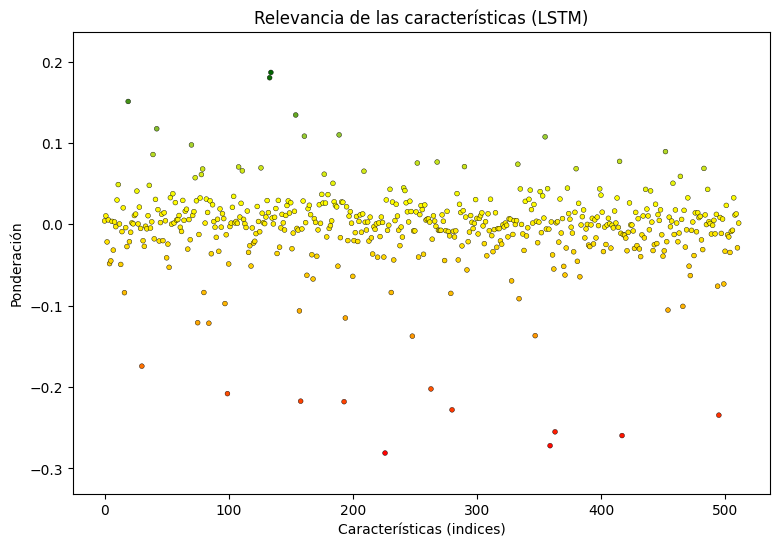

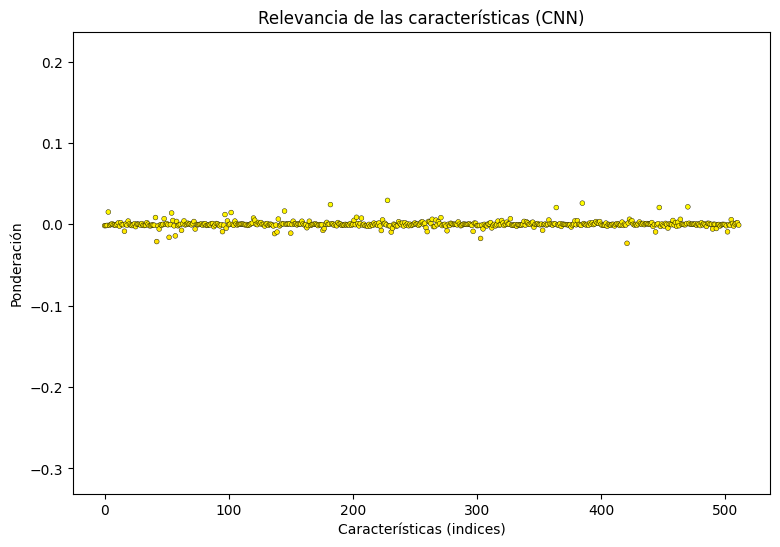

[ 0.00416639  0.01038399 -0.02159985 ...  0.00140492  0.00195266
 -0.00096104]


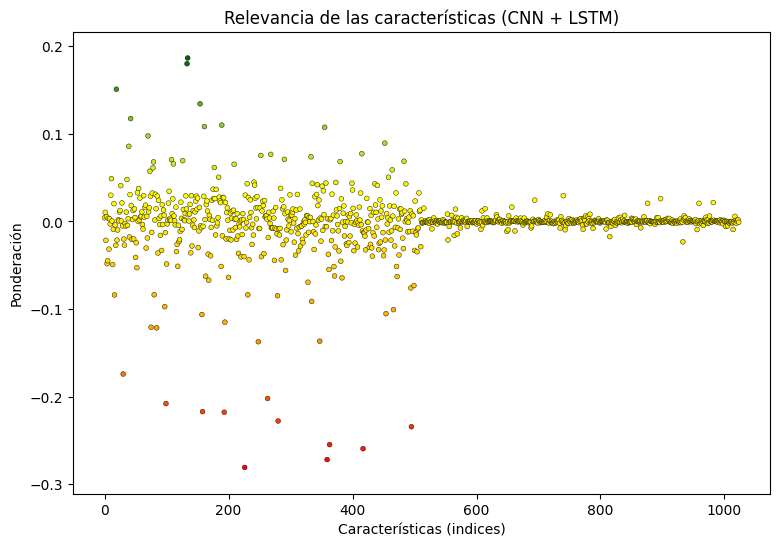

In [20]:

import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


w = np.loadtxt('array_importancias_Combination_fc_2.txt')

norm_w = (w - w.min()) / (w.max() - w.min())


# Define the tick labels
y_tick_labels = ['LSTM', 'CNN']



# Assuming you have the array 'data' with shape (2, 512)
for i in range(w.shape[0]):
    row = w[i]
    norm_row = norm_w[i]
    name = y_tick_labels[i]

    # Define the custom colors and the colormap
    colors = [(0, "red"), (1/3, "orange"), (2/3, "yellow"), (5/6, "yellowgreen"), (1, "darkgreen")]
    cmap_name = 'custom_colormap'
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

    # Create a color array based on the normalized importance values
    # Here, I'm using the custom colormap to map the normalized values to the specified colors
    colors = custom_cmap(norm_row)

    # Create a scatter plot
    
    plt.figure(figsize=(9, 6))
    plt.scatter(range(len(row)), row, c=colors, s=12, alpha=1, edgecolors='black', linewidths=0.3)
    plt.xlabel('Características (indices)')
    plt.ylabel('Ponderación')
    plt.title(f'Relevancia de las características ({name})')
    plt.ylim(w.min() - 0.05, w.max() + 0.05)
    plt.show()




w = w.flatten()
print(w)
norm_w = norm_w.flatten()

# Define the custom colors and the colormap
colors = [(0, "red"), (1/3, "orange"), (2/3, "yellow"), (5/6, "yellowgreen"), (1, "darkgreen")]
cmap_name = 'custom_colormap'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

# Create a color array based on the normalized importance values
# Here, I'm using the custom colormap to map the normalized values to the specified colors
colors = custom_cmap(norm_w)

# Create a scatter plot

plt.figure(figsize=(9, 6))
plt.scatter(range(len(w)), w, c=colors, s=12, alpha=1, edgecolors='black', linewidths=0.3)
plt.xlabel('Características (indices)')
plt.ylabel('Ponderación')
plt.title(f'Relevancia de las características (CNN + LSTM)')
plt.ylim(w.min() - 0.03, w.max() + 0.03)
plt.show()


### 5.2. Combination based off of the convex combination of characteristics with a unique parameter alpha

In [10]:
class Alpha_Combination_VAD(VoiceActivityDetectorBase):
    """
    Voice Activity Detector (VAD) model for audio classification using a CNN and LSTM Combination.

    Args:
        input_size (int): Size of the input features.
        output_size (int): Size of the output layer.
        threshold (float, optional): Threshold value for classification (default: 0.5).
        pooling (nn.Module, optional): Pooling function to use (default: nn.MaxPool2d(kernel_size=2, stride=2)).

    Attributes:
        cnn (nn.Sequential): Sequential CNN layers.
        fc (nn.Linear): Fully connected layer for classification.
        threshold (float): Threshold value for classification.
        pooling (nn.Module): Pooling layer.

    Methods:
        forward(x): Forward pass of the model.
        train_model(audio_dataloader, label_dataloader, criterion, optimizer, epochs, scheduler=None):
            Train the model.
        predict_prob(audio_dataloader): Predict probabilities of audio samples.
        predict_class(audio_dataloader): Predict classes (0 or 1) based on probabilities.
        pred_from_prob(probabilities): Convert probabilities to classes based on the threshold.
        eval_model(audio_dataloader, label_dataloader): Evaluate the model on the provided data.
    """

    def __init__(
        self,
        input_size,
        pooling,
        feature_length,
        kernel_size,
        stride=-1,
        threshold=0.5,
    ):
        super(Alpha_Combination_VAD, self).__init__(threshold)
        if stride == -1:
            stride = kernel_size
            
        self.pooling = pooling
        # Define the CNN and fully connected layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, feature_length, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
            self.pooling
        )
        self.lstm = nn.LSTM(input_size, feature_length, num_layers, batch_first=True)
        self.fc = nn.Linear(feature_length, 1)
        self.alpha = nn.Parameter(torch.tensor([0.5]))
        self.stride = stride
        self.kernel_size = kernel_size
        self.feature_length = feature_length


    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, height, width).

        Returns:
            output_logit (torch.Tensor): Predicted logits of shape (output_size, batch_size).
        """
        x_cnn = x
        x_lstm = torch.rot90(x, k=3, dims=(2, 1))
        
        batch_size = x_cnn.size(0)
        height = x_cnn.size(1)
        width = x_cnn.size(2)
        x_cnn = x_cnn.view((batch_size, 1, height, width))
        x_cnn = self.cnn(x_cnn)
        y_cnn = x_cnn.view(batch_size, -1)

        _, (hidden, _) = self.lstm(x_lstm)
        y_lstm = hidden[-1]

        norm_alpha = torch.sigmoid(self.alpha)

        y_ens = ((1 - norm_alpha) * y_lstm) + (norm_alpha * y_cnn)
        output = self.fc(y_ens)
        
        return output.flatten()

    def save_model(self, filepath):
        """
        Save the model to a file.

        Args:
            filepath (str): Path to the file where the model will be saved.
        """
        torch.save({
            'state_dict': self.state_dict(),
            'hyperparams': {
                'input_size': self.lstm.input_size,
                'feature_length': self.feature_length,
                'kernel_size': self.kernel_size,
                'stride': self.stride,
                'threshold': self.threshold
            }
        }, filepath)

    @classmethod
    def load_model(cls, filepath, pooling):
        """
        Load the model from a file.

        Args:
            filepath (str): Path to the file where the model is saved.

        Returns:
            Alpha_Combination_VAD: Loaded model.
        """
        checkpoint = torch.load(filepath)
        
        model = cls(
            checkpoint['hyperparams']['input_size'],
            pooling,
            checkpoint['hyperparams']['feature_length'],
            checkpoint['hyperparams']['kernel_size'],
            checkpoint['hyperparams']['stride'],
            checkpoint['hyperparams']['threshold']
        )
        model.load_state_dict(checkpoint['state_dict'])
        model = model.to(dtype=torch.double)
        return model

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from Preprocessing import *
import pandas as pd

SHUFFLE = False

positive_class_label = 'speech'
negative_class_label = 'non-speech'

csv_file = 'spectrogram_dataset_augmented_balanced.csv'
preprocess_function = preprocess_audio_spectrogram


data = pd.read_csv(csv_file, index_col=None)
N = data.shape[0]
df_speech = data[data['label'] == 'speech'].sample(n=N//2, random_state=42)
df_non_speech = data[data['label'] == 'non-speech'].sample(n=N//2, random_state=42)

data = pd.concat([df_speech, df_non_speech], ignore_index=True)

# Split the DataFrame into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)



train_audio_dataset = AudioDataset(train_data, preprocess_function)
test_audio_dataset = AudioDataset(test_data, preprocess_function)

train_label_dataset = LabelDataset(train_data, positive_class_label)
test_label_dataset = LabelDataset(test_data, positive_class_label)

# Create data loaders for training, validation, and test sets
batch_size = 16
train_audio_loader = DataLoader(train_audio_dataset, batch_size=batch_size, shuffle=SHUFFLE)
test_audio_loader = DataLoader(test_audio_dataset, batch_size=batch_size, shuffle=SHUFFLE)

train_label_loader = DataLoader(train_label_dataset, batch_size=batch_size, shuffle=SHUFFLE)
test_label_loader = DataLoader(test_label_dataset, batch_size=batch_size, shuffle=SHUFFLE)


example = train_audio_dataset[0]
plt.imshow(example, cmap='hot', aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')  # Barra de color opcional
plt.xlabel('Cuadros de Tiempo')
plt.ylabel('Bandas de Frecuencia')
plt.title('example')
plt.show()
print(example.shape)

input_height = example.shape[0]
input_width = example.shape[1]
learning_rate = 1e-4

print('dataset_size: ', len(train_audio_dataset))

input_size = input_height
hidden_size = 512
num_layers = 1

pooling = nn.MaxPool2d(kernel_size=(1, input_width - 2 + 1))
out_channels = 512
kernel_size = (input_height, 2)
stride = (input_height, 1)


model = Alpha_Combination_VAD(input_size, pooling, hidden_size, kernel_size, stride)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
scheduler = lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)
num_epochs = 15


model = model.to(dtype=torch.double)
model.train_model(train_audio_loader, train_label_loader, criterion, optimizer, num_epochs, learning_rate=learning_rate, scheduler=scheduler)
acc = model.eval_model(test_audio_loader, test_label_loader)
print(f'\n\nTest acc: {acc:4.3%}\n\n')
pred = model.predict_class(test_audio_loader)

test_labels = np.array(test_data['label'] == positive_class_label)
test_labels = test_labels.astype(np.int32)
test_files = test_data['file_path']
for file, true_label, pred_label in zip(test_files, test_labels, pred):
    print(f'{file} ({true_label}):  {pred_label}')



model.save_model(f'Combination_alpha.pt')

from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true_labels and predicted_labels

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, pred)

# Plot the confusion matrix
label_names = ["non-speech", "speech"]
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(label_names)
ax.yaxis.set_ticklabels(label_names)

plt.show()

# Compute precision and recall
precision = precision_score(test_labels, pred, average=None)
recall = recall_score(test_labels, pred, average=None)

# Print precision and recall for each class
for i, label in enumerate(label_names):
    print(f"{label} Precision: {precision[i]:.2%}")
    print(f"{label} Recall: {recall[i]:.2%}")

In [46]:
print(1-torch.sigmoid(model.alpha)) # Importancia de la LSTM

tensor([0.6064], device='cuda:0', dtype=torch.float64, grad_fn=<RsubBackward1>)


### 5.3. Combination based off of the convex combination of characteristics with a vector of parameters alpha

In [21]:
class Alpha_Vector_Combination_VAD(VoiceActivityDetectorBase):
    """
    Voice Activity Detector (VAD) model for audio classification using a CNN and LSTM Combination.

    Args:
        input_size (int): Size of the input features.
        output_size (int): Size of the output layer.
        threshold (float, optional): Threshold value for classification (default: 0.5).
        pooling (nn.Module, optional): Pooling function to use (default: nn.MaxPool2d(kernel_size=2, stride=2)).

    Attributes:
        cnn (nn.Sequential): Sequential CNN layers.
        fc (nn.Linear): Fully connected layer for classification.
        threshold (float): Threshold value for classification.
        pooling (nn.Module): Pooling layer.

    Methods:
        forward(x): Forward pass of the model.
        train_model(audio_dataloader, label_dataloader, criterion, optimizer, epochs, scheduler=None):
            Train the model.
        predict_prob(audio_dataloader): Predict probabilities of audio samples.
        predict_class(audio_dataloader): Predict classes (0 or 1) based on probabilities.
        pred_from_prob(probabilities): Convert probabilities to classes based on the threshold.
        eval_model(audio_dataloader, label_dataloader): Evaluate the model on the provided data.
    """

    def __init__(
        self,
        input_size,
        pooling,
        feature_length,
        kernel_size,
        stride=-1,
        threshold=0.5,
    ):
        super(Alpha_Vector_Combination_VAD, self).__init__(threshold)
        if stride == -1:
            stride = kernel_size
            
        # Define the CNN and fully connected layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, feature_length, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
            pooling
        )
        self.lstm = nn.LSTM(input_size, feature_length, num_layers, batch_first=True)
        self.fc = nn.Linear(feature_length, 1)
        self.alpha = nn.Parameter(torch.Tensor(feature_length*[0.5]))
        self.stride = stride
        self.kernel_size = kernel_size
        self.feature_length = feature_length


    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, height, width).

        Returns:
            output_logit (torch.Tensor): Predicted logits of shape (output_size, batch_size).
        """
        x_cnn = x
        x_lstm = torch.rot90(x, k=3, dims=(2, 1))
        
        batch_size = x_cnn.size(0)
        height = x_cnn.size(1)
        width = x_cnn.size(2)
        x_cnn = x_cnn.view((batch_size, 1, height, width))
        x_cnn = self.cnn(x_cnn)
        y_cnn = x_cnn.view(batch_size, -1)

        _, (hidden, _) = self.lstm(x_lstm)
        y_lstm = hidden[-1]

        norm_alpha = torch.sigmoid(self.alpha)

        y_ens = ((1 - norm_alpha) * y_lstm) + (norm_alpha * y_cnn)
        output = self.fc(y_ens)
        
        return output.flatten()

    def save_model(self, filepath):
        """
        Save the model to a file.

        Args:
            filepath (str): Path to the file where the model will be saved.
        """
        torch.save({
            'state_dict': self.state_dict(),
            'hyperparams': {
                'input_size': self.lstm.input_size,
                'feature_length': self.feature_length,
                'kernel_size': self.kernel_size,
                'stride': self.stride,
                'threshold': self.threshold
            }
        }, filepath)

    @classmethod
    def load_model(cls, filepath, pooling):
        """
        Load the model from a file.

        Args:
            filepath (str): Path to the file where the model is saved.

        Returns:
            Alpha_Combination_VAD: Loaded model.
        """
        checkpoint = torch.load(filepath)
        
        model = cls(
            checkpoint['hyperparams']['input_size'],
            pooling,
            checkpoint['hyperparams']['feature_length'],
            checkpoint['hyperparams']['kernel_size'],
            checkpoint['hyperparams']['stride'],
            checkpoint['hyperparams']['threshold']
        )
        model.load_state_dict(checkpoint['state_dict'])
        model = model.to(dtype=torch.double)
        return model

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from Preprocessing import *
import pandas as pd

SHUFFLE = False

positive_class_label = 'speech'
negative_class_label = 'non-speech'

csv_file = 'spectrogram_dataset_augmented_balanced.csv'
preprocess_function = preprocess_audio_spectrogram


data = pd.read_csv(csv_file, index_col=None)
N = data.shape[0]
df_speech = data[data['label'] == 'speech'].sample(n=N//2, random_state=42)
df_non_speech = data[data['label'] == 'non-speech'].sample(n=N//2, random_state=42)

data = pd.concat([df_speech, df_non_speech], ignore_index=True)

# Split the DataFrame into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


train_audio_dataset = AudioDataset(train_data, preprocess_function)
test_audio_dataset = AudioDataset(test_data, preprocess_function)

train_label_dataset = LabelDataset(train_data, positive_class_label)
test_label_dataset = LabelDataset(test_data, positive_class_label)

# Create data loaders for training, validation, and test sets
batch_size = 16
train_audio_loader = DataLoader(train_audio_dataset, batch_size=batch_size, shuffle=SHUFFLE)
test_audio_loader = DataLoader(test_audio_dataset, batch_size=batch_size, shuffle=SHUFFLE)

train_label_loader = DataLoader(train_label_dataset, batch_size=batch_size, shuffle=SHUFFLE)
test_label_loader = DataLoader(test_label_dataset, batch_size=batch_size, shuffle=SHUFFLE)


example = train_audio_dataset[0]
plt.imshow(example, cmap='hot', aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')  # Barra de color opcional
plt.xlabel('Cuadros de Tiempo')
plt.ylabel('Bandas de Frecuencia')
plt.title('example')
plt.show()
print(example.shape)

input_height = example.shape[0]
input_width = example.shape[1]
learning_rate = 1e-4


input_size = input_height
hidden_size = 512
num_layers = 1

pooling = nn.MaxPool2d(kernel_size=(1, input_width - 2 + 1))
out_channels = 512
kernel_size = (input_height, 2)
stride = (input_height, 1)

model = Alpha_Vector_Combination_VAD(input_size, pooling, hidden_size, kernel_size, stride)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
scheduler = lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.3)
num_epochs = 25


model = model.to(dtype=torch.double)
model.train_model(train_audio_loader, train_label_loader, criterion, optimizer, num_epochs, learning_rate=learning_rate, scheduler=scheduler)
acc = model.eval_model(test_audio_loader, test_label_loader)
print(f'\n\nTest acc: {acc:4.3%}\n\n')
pred = model.predict_class(test_audio_loader)

test_labels = np.array(test_data['label'] == positive_class_label)
test_labels = test_labels.astype(np.int32)
test_files = test_data['file_path']
for file, true_label, pred_label in zip(test_files, test_labels, pred):
    print(f'{file} ({true_label}):  {pred_label}')



model.save_model(f'alpha_vector_Combination.pt')

from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true_labels and predicted_labels

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, pred)

# Plot the confusion matrix
label_names = ["non-speech", "speech"]
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(label_names)
ax.yaxis.set_ticklabels(label_names)

plt.show()

# Compute precision and recall
precision = precision_score(test_labels, pred, average=None)
recall = recall_score(test_labels, pred, average=None)

# Print precision and recall for each class
for i, label in enumerate(label_names):
    print(f"{label} Precision: {precision[i]:.2%}")
    print(f"{label} Recall: {recall[i]:.2%}")

torch.Size([512])
importancia media de las características: 0.5979260371074278


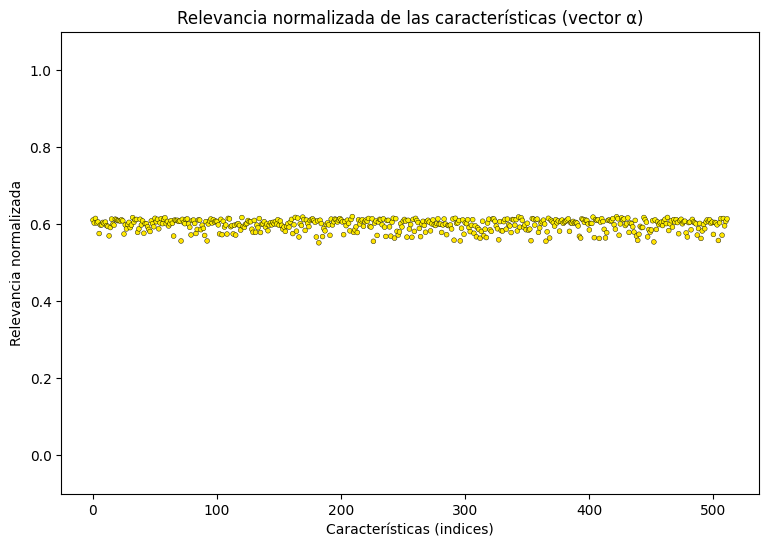

tensor(0.6199, dtype=torch.float64) tensor(0.5518, dtype=torch.float64)


In [71]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates
import ast
import re 
import math
import matplotlib.colors as mcolors

print(model.alpha.shape)

w = model.alpha.cpu().clone().detach().numpy()


name = 'vector α'


w = torch.sigmoid(torch.tensor(w))
mean_importance = w.mean().item()
print("importancia media de las características:", mean_importance)
# print("normalized norm: ", torch.sigmoid(torch.tensor(l2_norm)))


# Define the custom colors and the colormap
colors = [(0, "red"), (1/3, "orange"), (2/3, "yellow"), (5/6, "yellowgreen"), (1, "darkgreen")]
cmap_name = 'custom_colormap'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

# Create a color array based on the normalized importance values
# Here, I'm using the custom colormap to map the normalized values to the specified colors
colors = custom_cmap(w)

# Create a scatter plot
plt.figure(figsize=(9, 6))
plt.scatter(range(len(w)), w, c=colors, s=12, alpha=1, edgecolors='black', linewidths=0.3)
plt.xlabel('Características (indices)')
plt.ylabel('Relevancia normalizada')
plt.title(f'Relevancia normalizada de las características ({name})')
plt.ylim(-0.1, 1.1)
plt.show()

print(w.max(), w.min())


### 5.2. Combination based off of the convex combination of characteristics with tow parameter vectors alpha and beta

In [4]:

class Alpha_Beta_Combination_VAD(VoiceActivityDetectorBase):
    """
    Voice Activity Detector (VAD) model for audio classification using a CNN and LSTM Combination.

    Args:
        input_size (int): Size of the input features.
        output_size (int): Size of the output layer.
        threshold (float, optional): Threshold value for classification (default: 0.5).
        pooling (nn.Module, optional): Pooling function to use (default: nn.MaxPool2d(kernel_size=2, stride=2)).

    Attributes:
        cnn (nn.Sequential): Sequential CNN layers.
        fc (nn.Linear): Fully connected layer for classification.
        threshold (float): Threshold value for classification.
        pooling (nn.Module): Pooling layer.

    Methods:
        forward(x): Forward pass of the model.
        train_model(audio_dataloader, label_dataloader, criterion, optimizer, epochs, scheduler=None):
            Train the model.
        predict_prob(audio_dataloader): Predict probabilities of audio samples.
        predict_class(audio_dataloader): Predict classes (0 or 1) based on probabilities.
        pred_from_prob(probabilities): Convert probabilities to classes based on the threshold.
        eval_model(audio_dataloader, label_dataloader): Evaluate the model on the provided data.
    """

    def __init__(
        self,
        input_size,
        pooling,
        feature_length,
        kernel_size,
        stride=-1,
        threshold=0.5,
    ):
        super(Alpha_Beta_Combination_VAD, self).__init__(threshold)
        if stride == -1:
            stride = kernel_size
            
        # Define the CNN and fully connected layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, feature_length, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
            pooling
        )
        self.lstm = nn.LSTM(input_size, feature_length, num_layers, batch_first=True)
        self.fc = nn.Linear(feature_length, 1)
        self.alpha = nn.Parameter(torch.rand(feature_length))
        self.beta = nn.Parameter(torch.rand(feature_length))
        self.feature_length = feature_length
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, height, width).

        Returns:
            output_logit (torch.Tensor): Predicted logits of shape (output_size, batch_size).
        """
        x_cnn = x
        x_lstm = torch.rot90(x, k=3, dims=(2, 1))
        
        batch_size = x_cnn.size(0)
        height = x_cnn.size(1)
        width = x_cnn.size(2)
        x_cnn = x_cnn.view((batch_size, 1, height, width))
        x_cnn = self.cnn(x_cnn)
        y_cnn = x_cnn.view(batch_size, -1)

        _, (hidden, _) = self.lstm(x_lstm)
        y_lstm = hidden[-1]

        y_ens = (self.alpha * y_lstm) + (self.beta * y_cnn)
        output = self.fc(y_ens)
        
        return output.flatten()
    
    
    def save_model(self, filepath):
        """
        Save the model to a file.

        Args:
            filepath (str): Path to the file where the model will be saved.
        """
        torch.save({
            'state_dict': self.state_dict(),
            'hyperparams': {
                'input_size': self.lstm.input_size,
                'feature_length': self.feature_length,
                'kernel_size': self.kernel_size,
                'stride': self.stride,
                'threshold': self.threshold
            }
        }, filepath)

    @classmethod
    def load_model(cls, filepath, pooling):
        """
        Load the model from a file.

        Args:
            filepath (str): Path to the file where the model is saved.

        Returns:
            Alpha_Combination_VAD: Loaded model.
        """
        checkpoint = torch.load(filepath)
        
        model = cls(
            checkpoint['hyperparams']['input_size'],
            pooling,
            checkpoint['hyperparams']['feature_length'],
            checkpoint['hyperparams']['kernel_size'],
            checkpoint['hyperparams']['stride'],
            checkpoint['hyperparams']['threshold']
        )
        model.load_state_dict(checkpoint['state_dict'])
        model = model.to(dtype=torch.double)
        return model

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from Preprocessing import *
import pandas as pd

SHUFFLE = False

positive_class_label = 'speech'
negative_class_label = 'non-speech'

csv_file = 'spectrogram_dataset_augmented_balanced.csv'
preprocess_function = preprocess_audio_spectrogram


data = pd.read_csv(csv_file, index_col=None)
N = data.shape[0]
df_speech = data[data['label'] == 'speech'].sample(n=N//2, random_state=42)
df_non_speech = data[data['label'] == 'non-speech'].sample(n=N//2, random_state=42)

data = pd.concat([df_speech, df_non_speech], ignore_index=True)

# Split the DataFrame into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


train_audio_dataset = AudioDataset(train_data, preprocess_function)
test_audio_dataset = AudioDataset(test_data, preprocess_function)

train_label_dataset = LabelDataset(train_data, positive_class_label)
test_label_dataset = LabelDataset(test_data, positive_class_label)

# Create data loaders for training, validation, and test sets
batch_size = 16
train_audio_loader = DataLoader(train_audio_dataset, batch_size=batch_size, shuffle=SHUFFLE)
test_audio_loader = DataLoader(test_audio_dataset, batch_size=batch_size, shuffle=SHUFFLE)

train_label_loader = DataLoader(train_label_dataset, batch_size=batch_size, shuffle=SHUFFLE)
test_label_loader = DataLoader(test_label_dataset, batch_size=batch_size, shuffle=SHUFFLE)


example = train_audio_dataset[0]
plt.imshow(example, cmap='hot', aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')  # Barra de color opcional
plt.xlabel('Cuadros de Tiempo')
plt.ylabel('Bandas de Frecuencia')
plt.title('example')
plt.show()
print(example.shape)

input_height = example.shape[0]
input_width = example.shape[1]
learning_rate = 1e-4

print('dataset_size: ', len(train_audio_dataset))

input_size = input_height
hidden_size = 512
num_layers = 1

pooling = nn.MaxPool2d(kernel_size=(1, input_width - 2 + 1))
out_channels = 512
kernel_size = (input_height, 2)
stride = (input_height, 1)

model = Alpha_Beta_Combination_VAD(input_size, pooling, hidden_size, kernel_size, stride)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
scheduler = lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)
num_epochs = 15


model = model.to(dtype=torch.double)
model.train_model(train_audio_loader, train_label_loader, criterion, optimizer, num_epochs, learning_rate=learning_rate, scheduler=scheduler)
acc = model.eval_model(test_audio_loader, test_label_loader)
print(f'\n\nTest acc: {acc:4.3%}\n\n')
pred = model.predict_class(test_audio_loader)

test_labels = np.array(test_data['label'] == positive_class_label)
test_labels = test_labels.astype(np.int32)
test_files = test_data['file_path']
for file, true_label, pred_label in zip(test_files, test_labels, pred):
    print(f'{file} ({true_label}):  {pred_label}')



from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true_labels and predicted_labels

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, pred)

# Plot the confusion matrix
label_names = ["non-speech", "speech"]
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(label_names)
ax.yaxis.set_ticklabels(label_names)

plt.show()

# Compute precision and recall
precision = precision_score(test_labels, pred, average=None)
recall = recall_score(test_labels, pred, average=None)

# Print precision and recall for each class
for i, label in enumerate(label_names):
    print(f"{label} Precision: {precision[i]:.2%}")
    print(f"{label} Recall: {recall[i]:.2%}")

model.save_model('alpha_beta_Combination.pt')

tensor(False, device='cuda:0')
importancia media de las características: 0.5679514385108078


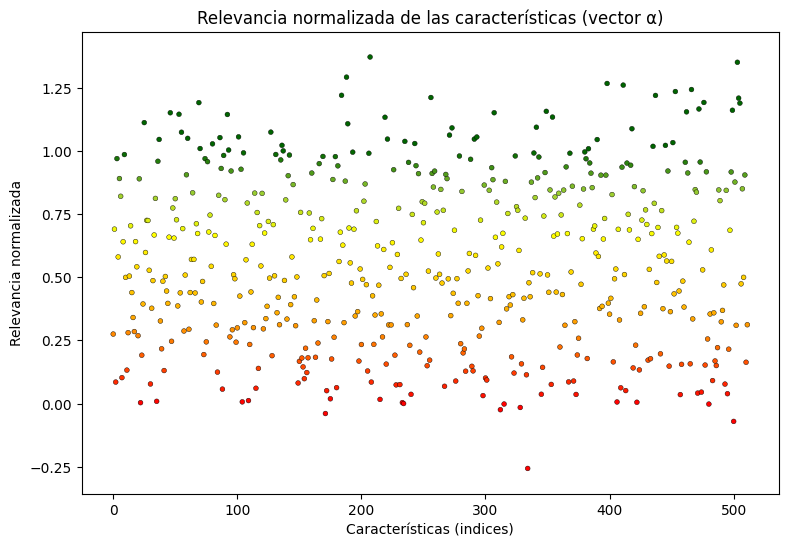

1.370917597531672 -0.2567916454107902
importancia media de las características: 0.3894175531275912


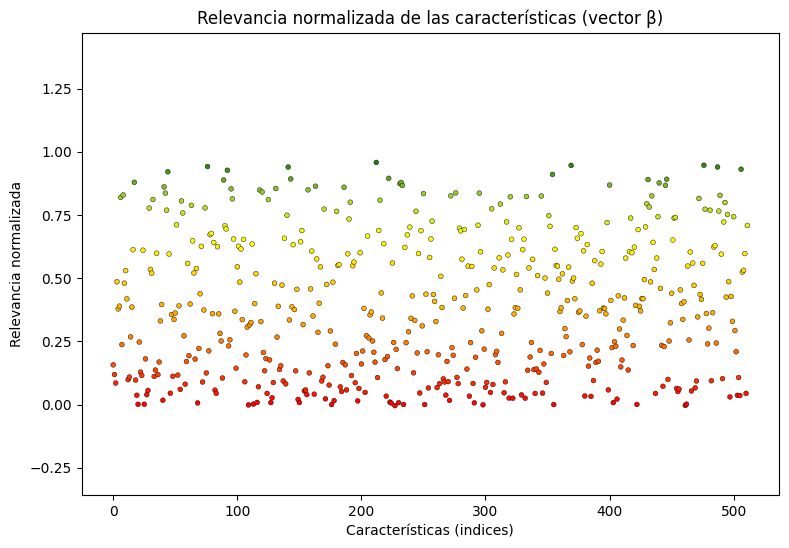

0.9578225386958888 -0.004404673128548215
importancia media de las características: 0.5066894394668936


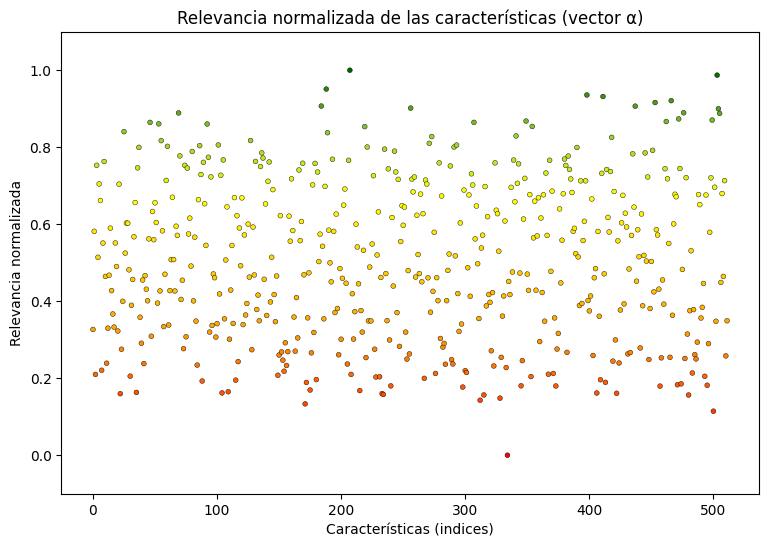

1.0 0.0
importancia media de las características: 0.40928194652636174


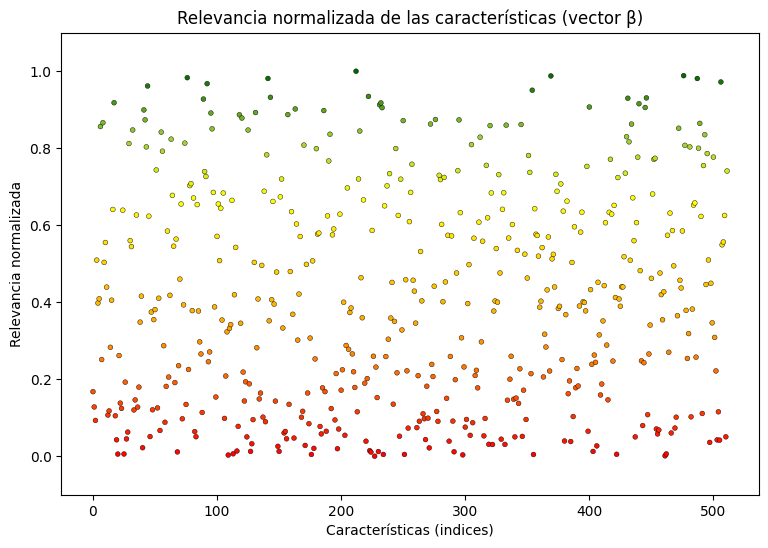

1.0 0.0
importancia media de las características: 0.6348121796340054


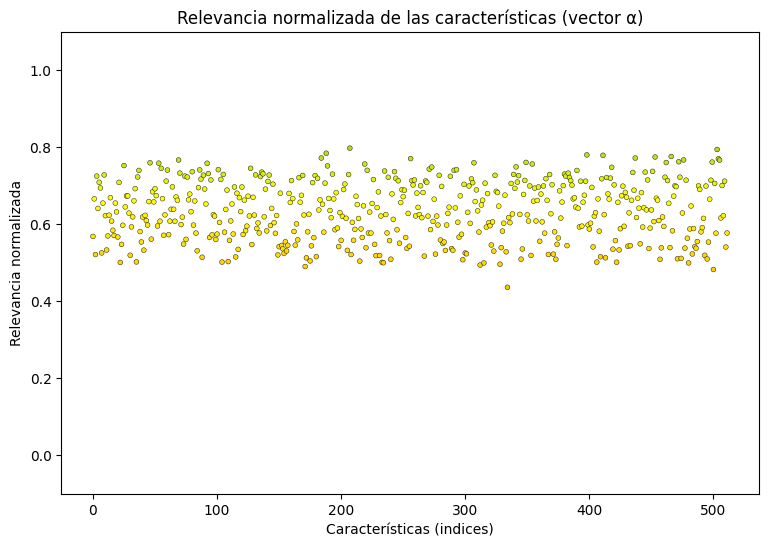

0.7975283648011071 0.4361525557308432
importancia media de las características: 0.5943684280906429


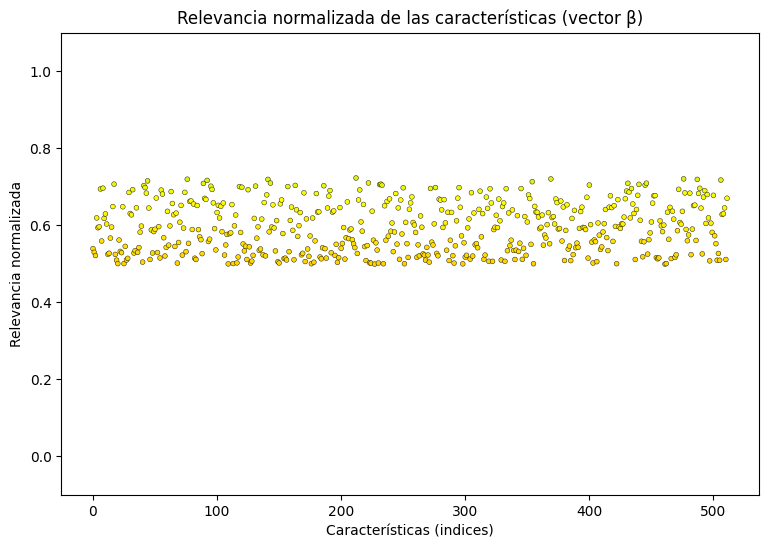

0.7226856293557281 0.4988988334981866


In [30]:
print((model.alpha == model.beta).any())



import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates
import ast
import re 
import math
import matplotlib.colors as mcolors

max_ab = max(model.alpha.max().item(), model.beta.max().item())
min_ab = min(model.alpha.min().item(), model.beta.min().item())

for w, n in [(model.alpha, 'α'), (model.beta, 'β')]:
    w = w.cpu().clone().detach().numpy()


    name = 'vector '+n


    # w = torch.sigmoid(torch.tensor(w))
    mean_importance = w.mean().item()
    print("importancia media de las características:", mean_importance)
    # print("normalized norm: ", torch.sigmoid(torch.tensor(l2_norm)))


    # Define the custom colors and the colormap
    colors = [(0, "red"), (1/3, "orange"), (2/3, "yellow"), (5/6, "yellowgreen"), (1, "darkgreen")]
    cmap_name = 'custom_colormap'
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

    # Create a color array based on the normalized importance values
    # Here, I'm using the custom colormap to map the normalized values to the specified colors
    colors = custom_cmap(w)

    # Create a scatter plot
    plt.figure(figsize=(9, 6))
    plt.scatter(range(len(w)), w, c=colors, s=12, alpha=1, edgecolors='black', linewidths=0.3)
    plt.xlabel('Características (indices)')
    plt.ylabel('Relevancia normalizada')
    plt.title(f'Relevancia normalizada de las características ({name})')
    plt.ylim(min_ab-0.1, max_ab+0.1)
    plt.show()

    print(w.max(), w.min())




for w, n in [(model.alpha, 'α'), (model.beta, 'β')]:
    w = w.cpu().clone().detach().numpy()

    w = (w - w.min()) / (w.max() - w.min())

    name = 'vector '+n


    # w = torch.sigmoid(torch.tensor(w))
    mean_importance = w.mean().item()
    print("importancia media de las características:", mean_importance)
    # print("normalized norm: ", torch.sigmoid(torch.tensor(l2_norm)))


    # Define the custom colors and the colormap
    colors = [(0, "red"), (1/3, "orange"), (2/3, "yellow"), (5/6, "yellowgreen"), (1, "darkgreen")]
    cmap_name = 'custom_colormap'
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

    # Create a color array based on the normalized importance values
    # Here, I'm using the custom colormap to map the normalized values to the specified colors
    colors = custom_cmap(w)

    # Create a scatter plot
    plt.figure(figsize=(9, 6))
    plt.scatter(range(len(w)), w, c=colors, s=12, alpha=1, edgecolors='black', linewidths=0.3)
    plt.xlabel('Características (indices)')
    plt.ylabel('Relevancia normalizada')
    plt.title(f'Relevancia normalizada de las características ({name})')
    plt.ylim(0-0.1, 1+0.1)
    plt.show()

    print(w.max(), w.min())





for w, n in [(model.alpha, 'α'), (model.beta, 'β')]:

    w = torch.sigmoid(w.cpu().clone()) # - w.min()) / (w.max() - w.min())
    w = w.cpu().clone().detach().numpy()

    name = 'vector '+n


    # w = torch.sigmoid(torch.tensor(w))
    mean_importance = w.mean().item()
    print("importancia media de las características:", mean_importance)
    # print("normalized norm: ", torch.sigmoid(torch.tensor(l2_norm)))


    # Define the custom colors and the colormap
    colors = [(0, "red"), (1/3, "orange"), (2/3, "yellow"), (5/6, "yellowgreen"), (1, "darkgreen")]
    cmap_name = 'custom_colormap'
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

    # Create a color array based on the normalized importance values
    # Here, I'm using the custom colormap to map the normalized values to the specified colors
    colors = custom_cmap(w)

    # Create a scatter plot
    plt.figure(figsize=(9, 6))
    plt.scatter(range(len(w)), w, c=colors, s=12, alpha=1, edgecolors='black', linewidths=0.3)
    plt.xlabel('Características (indices)')
    plt.ylabel('Relevancia normalizada')
    plt.title(f'Relevancia normalizada de las características ({name})')
    plt.ylim(0-0.1, 1+0.1)
    plt.show()

    print(w.max(), w.min())

importancia media de las características: 0.17853388538321663


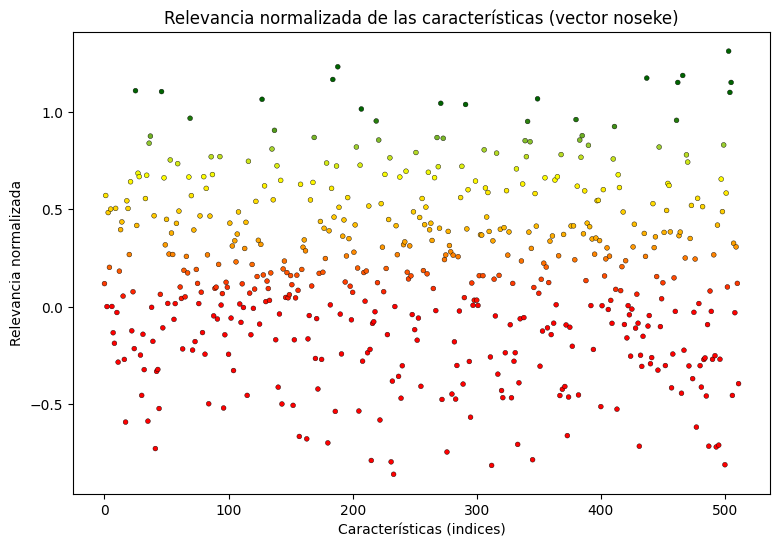

1.313585526564713 -0.8629237181899535


In [46]:

w = (model.alpha - model.beta)
w = w.cpu().clone().detach().numpy()

# w = (w - w.min()) / (w.max() - w.min())


name = 'vector noseke'


# w = torch.sigmoid(torch.tensor(w))
mean_importance = w.mean().item()
print("importancia media de las características:", mean_importance)
# print("normalized norm: ", torch.sigmoid(torch.tensor(l2_norm)))


# Define the custom colors and the colormap
colors = [(0, "red"), (1/3, "orange"), (2/3, "yellow"), (5/6, "yellowgreen"), (1, "darkgreen")]
cmap_name = 'custom_colormap'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

# Create a color array based on the normalized importance values
# Here, I'm using the custom colormap to map the normalized values to the specified colors
colors = custom_cmap(w)

# Create a scatter plot
plt.figure(figsize=(9, 6))
plt.scatter(range(len(w)), w, c=colors, s=12, alpha=1, edgecolors='black', linewidths=0.3)
plt.xlabel('Características (indices)')
plt.ylabel('Relevancia normalizada')
plt.title(f'Relevancia normalizada de las características ({name})')
plt.ylim(w.min()-0.1, w.max()+0.1)
plt.show()

print(w.max(), w.min())

importancia media de las características: 0.5426294232910179


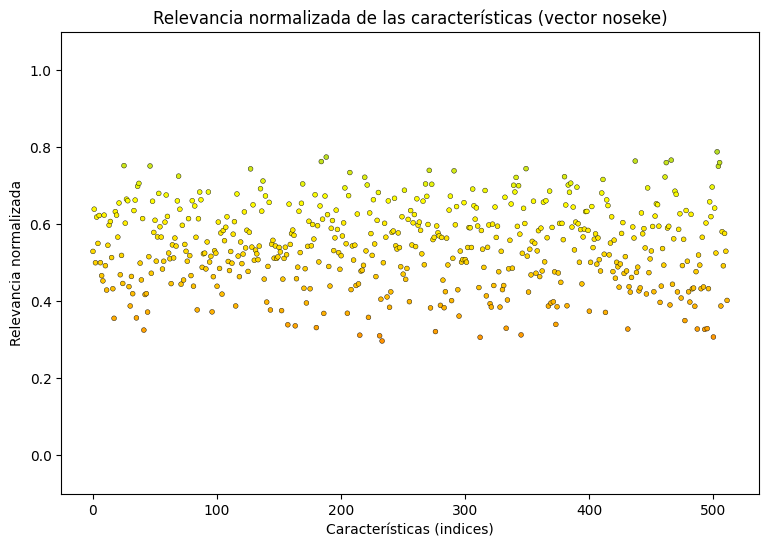

0.788112525690615 0.2967288592958862


In [48]:

w = torch.sigmoid(model.alpha - model.beta)
w = w.cpu().clone().detach().numpy()

# w = (w - w.min()) / (w.max() - w.min())


name = 'vector noseke'


# w = torch.sigmoid(torch.tensor(w))
mean_importance = w.mean().item()
print("importancia media de las características:", mean_importance)
# print("normalized norm: ", torch.sigmoid(torch.tensor(l2_norm)))


# Define the custom colors and the colormap
colors = [(0, "red"), (1/3, "orange"), (2/3, "yellow"), (5/6, "yellowgreen"), (1, "darkgreen")]
cmap_name = 'custom_colormap'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

# Create a color array based on the normalized importance values
# Here, I'm using the custom colormap to map the normalized values to the specified colors
colors = custom_cmap(w)

# Create a scatter plot
plt.figure(figsize=(9, 6))
plt.scatter(range(len(w)), w, c=colors, s=12, alpha=1, edgecolors='black', linewidths=0.3)
plt.xlabel('Características (indices)')
plt.ylabel('Relevancia normalizada')
plt.title(f'Relevancia normalizada de las características ({name})')
plt.ylim(0-0.1, 1+0.1)
plt.show()

print(w.max(), w.min())